In [1]:
# Import required packages
from typing import Dict, List, Optional, Set, Tuple
from omero.gateway import BlitzGateway, ColorHolder
from omero.model import MaskI
from omero.rtypes import (
    rdouble,
    rint,
    rstring,
    unwrap
)
import omero_rois
from mpl_toolkits.axes_grid1 import AxesGrid
import omero
from getpass import getpass
#from cellpose import models, utils,plot,io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import skimage as sk
from skimage.measure import label, regionprops,regionprops_table
from skimage import morphology
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from matplotlib.colors import Normalize
import pandas as pd
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [2]:
# Login to OMERO

def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, port=4064, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(6000)
    return conn

HOST = '35.8.197.106'
conn = connect(HOST, input("Username: "),
               getpass("OMERO Password: "))
print("Connected as {}".format(conn.getUser().getName()))

Username: JonathanSakkos
OMERO Password: ········
Connected as JonathanSakkos


In [3]:
imageId = 249
image = conn.getObject("Image", imageId)
print(image.getName(), image.getDescription())

Control-02.czi 


In [4]:
# View image channels separately

get_ipython().run_line_magic('matplotlib', 'inline')
pixels = image.getPrimaryPixels()
channels = image.getChannels()
plt.figure(figsize=(25, 20))
size_c = image.getSizeC()
for idx in range(0, size_c):
    plt.subplot(1, 5, idx+1)
    image_plane = pixels.getPlane(0, idx, 0)
    plt.imshow(image_plane, cmap='gray')
    plt.axis('off')
    plt.title(channels[idx].getLabel())
# List Channels (loads the Rendering settings to get channel colors)


for channel in image.getChannels():
    print('Channel:', channel.getLabel())
    print('Color:', channel.getColor().getRGB())
    print('Lookup table:', channel.getLut())
    print('Is reverse intensity?', channel.isReverseIntensity())

Channel: TagYFP
Color: (0, 255, 0)
Lookup table: None
Is reverse intensity? False
Channel: DsRed
Color: (255, 0, 0)
Lookup table: None
Is reverse intensity? False
Channel: TL Brightfield
Color: (255, 255, 255)
Lookup table: None
Is reverse intensity? False


In [5]:
def find_chan(image,channel):
    
    """
    Finds the specified channel number from the image metadata
    """
    
    for i, chan in enumerate(image.getChannels()):
        #print(i, dic)
        if chan.getLabel() == channel:
            return i
    return -1

# Find DsRed channel for segmentation

dsred_channel = find_chan(image,'DsRed')
dsred = pixels.getPlane(0, dsred_channel, 0)


In [6]:
def mask_to_arr(mask):
    t = unwrap(mask.theT)
    c = unwrap(mask.theC)
    z = unwrap(mask.theZ)

    x = int(mask.x.val)
    y = int(mask.y.val)
    w = int(mask.width.val)
    h = int(mask.height.val)

    mask_packed = mask.getBytes()
    # convert bytearray into something we can use
    intarray = np.frombuffer(mask_packed, dtype=np.uint8)
    binarray = np.unpackbits(intarray).astype(np.uint8)
    # truncate and reshape
    binarray = np.reshape(binarray[: (w * h)], (h, w))

    return binarray, (t, c, z, y, x, h, w)


ROI:  ID: 103


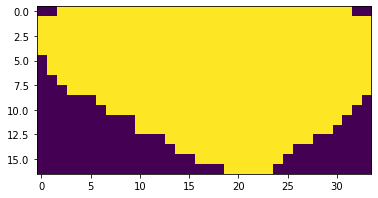

   Shape:
   id 1454



   Shape:
   id 1455



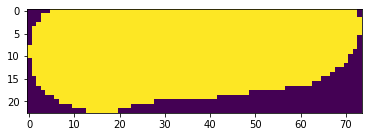

   Shape:
   id 1456



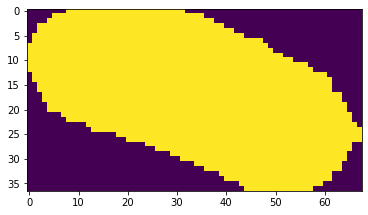

   Shape:
   id 1457



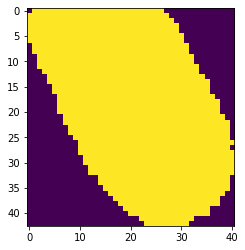

   Shape:
   id 1458



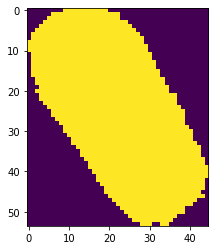

   Shape:
   id 1459



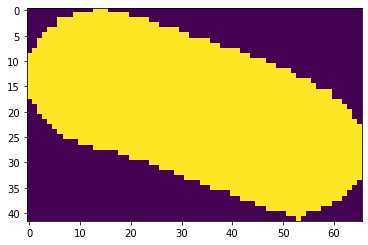

   Shape:
   id 1460



   Shape:
   id 1461



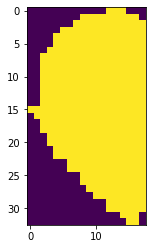

   Shape:
   id 1462



   Shape:
   id 1463



   Shape:
   id 1464



   Shape:
   id 1465



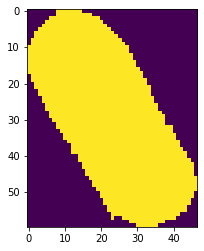

   Shape:
   id 1466



   Shape:
   id 1467



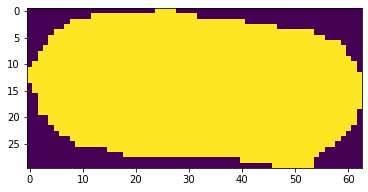

   Shape:
   id 1468



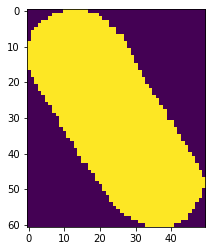

   Shape:
   id 1469



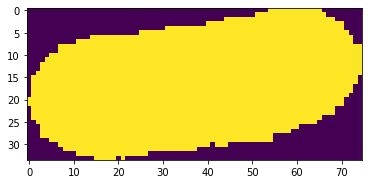

   Shape:
   id 1470



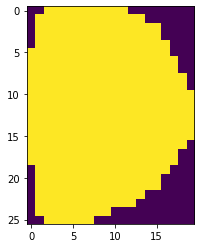

   Shape:
   id 1471



   Shape:
   id 1472



   Shape:
   id 1473



   Shape:
   id 1474



   Shape:
   id 1475



   Shape:
   id 1476



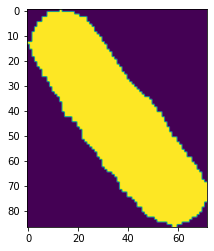

   Shape:
   id 1477



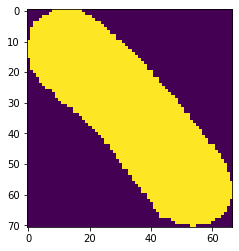

   Shape:
   id 1478



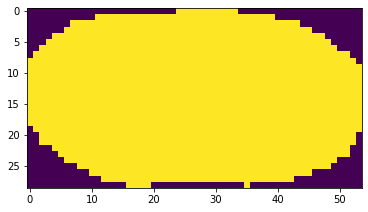

   Shape:
   id 1479



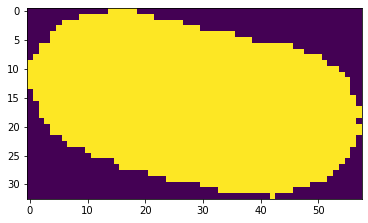

   Shape:
   id 1480



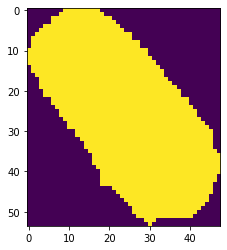

   Shape:
   id 1481



   Shape:
   id 1482



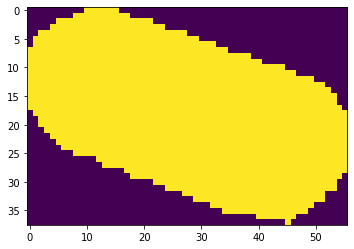

   Shape:
   id 1483



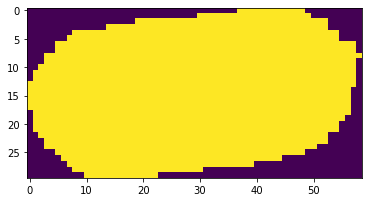

   Shape:
   id 1484



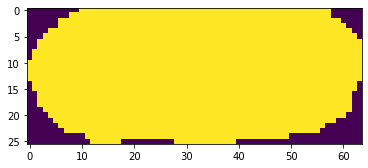

   Shape:
   id 1485



   Shape:
   id 1486



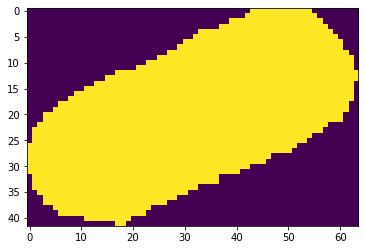

   Shape:
   id 1487



   Shape:
   id 1488



   Shape:
   id 1489



   Shape:
   id 1490



   Shape:
   id 1491



   Shape:
   id 1492



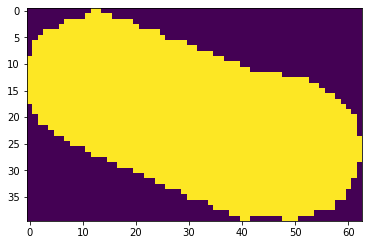

   Shape:
   id 1493



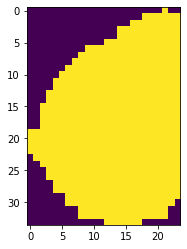

   Shape:
   id 1494



   Shape:
   id 1495



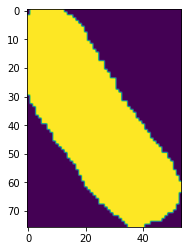

   Shape:
   id 1496



   Shape:
   id 1497



   Shape:
   id 1498



   Shape:
   id 1499



   Shape:
   id 1500



   Shape:
   id 1501



   Shape:
   id 1502



   Shape:
   id 1503



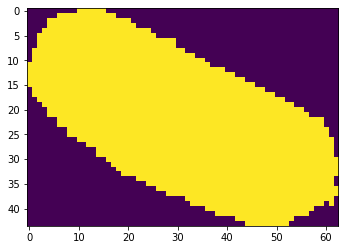

   Shape:
   id 1504



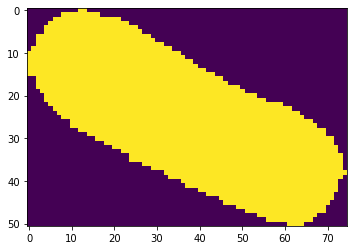

   Shape:
   id 1505



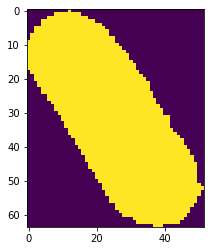

   Shape:
   id 1506



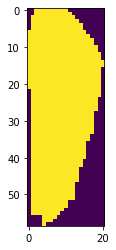

   Shape:
   id 1507



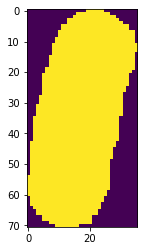

   Shape:
   id 1508



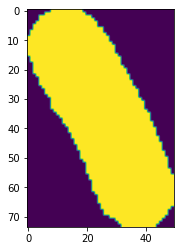

   Shape:
   id 1509



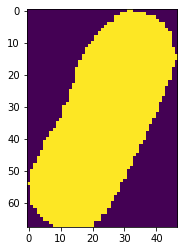

   Shape:
   id 1510



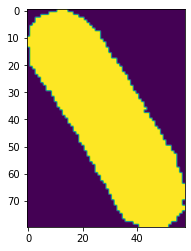

   Shape:
   id 1511



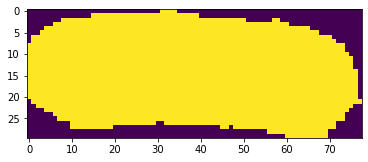

   Shape:
   id 1512



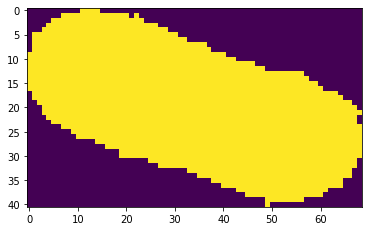

   Shape:
   id 1513



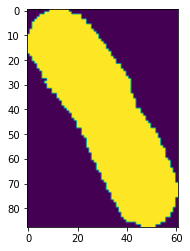

   Shape:
   id 1514



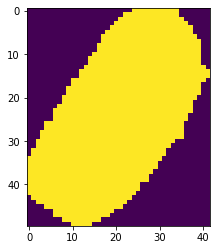

   Shape:
   id 1515



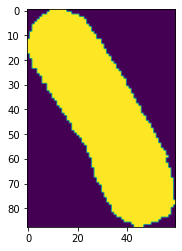

   Shape:
   id 1516



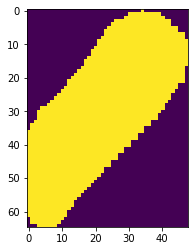

   Shape:
   id 1517



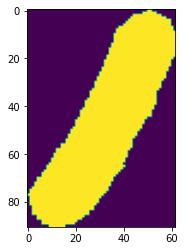

   Shape:
   id 1518



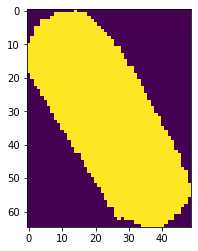

   Shape:
   id 1519



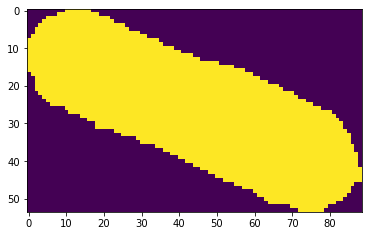

   Shape:
   id 1520



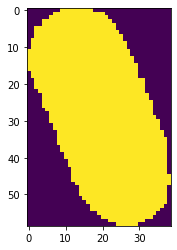

   Shape:
   id 1521



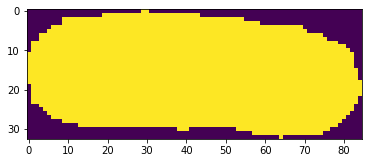

   Shape:
   id 1522



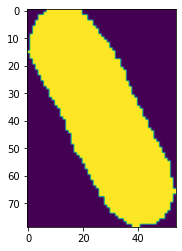

   Shape:
   id 1523



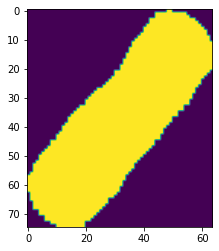

   Shape:
   id 1524



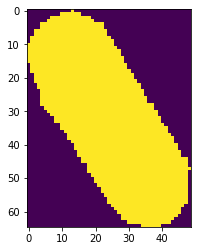

   Shape:
   id 1525



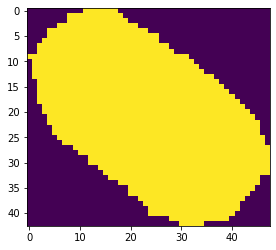

   Shape:
   id 1526



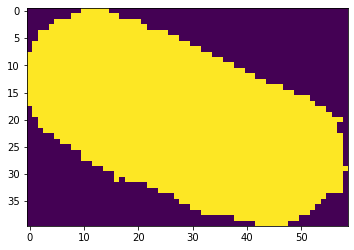

   Shape:
   id 1527



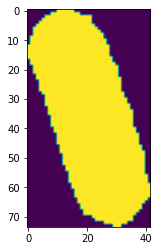

   Shape:
   id 1528



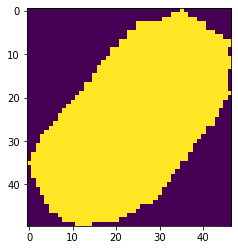

   Shape:
   id 1529



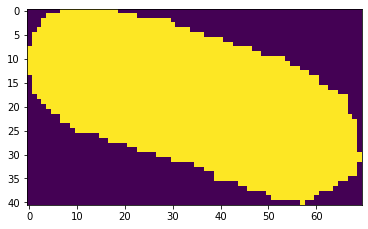

   Shape:
   id 1530



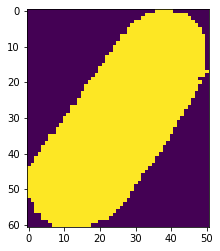

   Shape:
   id 1531



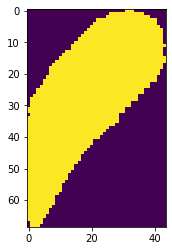

   Shape:
   id 1532



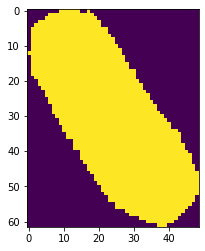

   Shape:
   id 1533



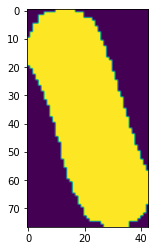

   Shape:
   id 1534



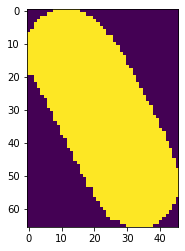

   Shape:
   id 1535



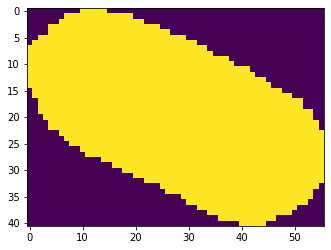

   Shape:
   id 1536



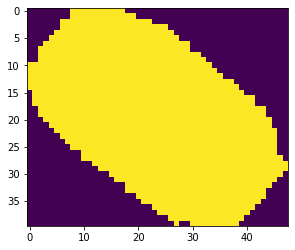

   Shape:
   id 1537



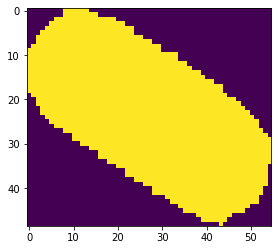

   Shape:
   id 1538



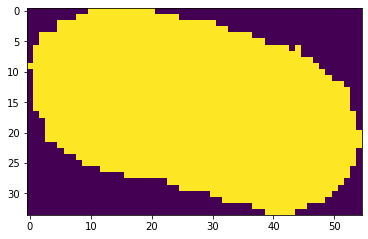

   Shape:
   id 1539



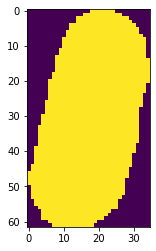

   Shape:
   id 1540



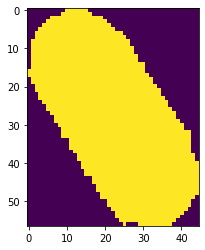

   Shape:
   id 1541



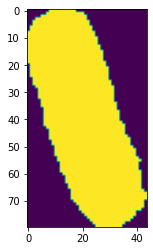

   Shape:
   id 1542



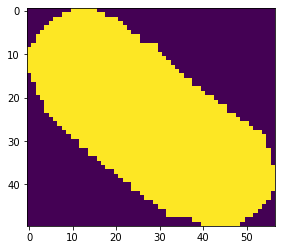

   Shape:
   id 1543



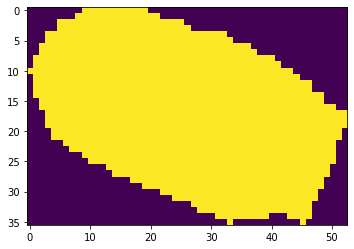

   Shape:
   id 1544



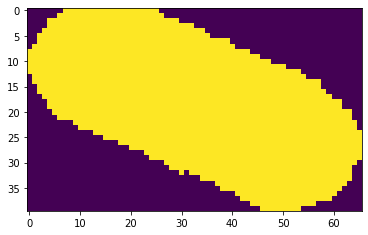

   Shape:
   id 1545



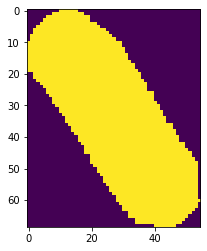

   Shape:
   id 1546



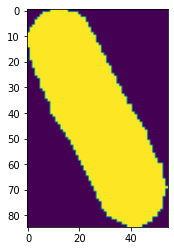

   Shape:
   id 1547



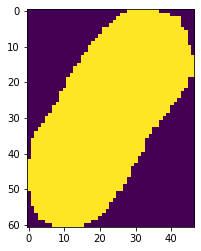

   Shape:
   id 1548



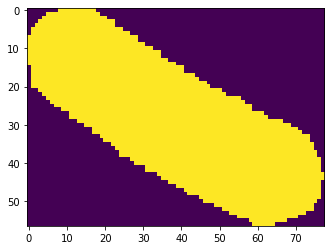

   Shape:
   id 1549



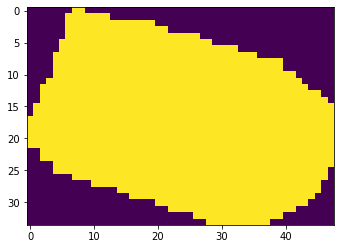

   Shape:
   id 1550



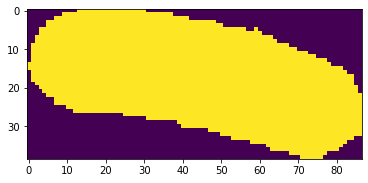

   Shape:
   id 1551



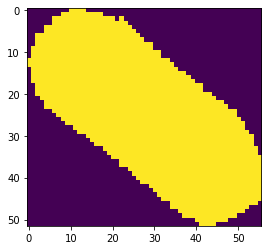

   Shape:
   id 1552



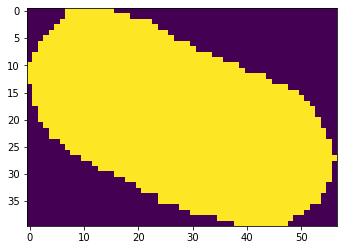

   Shape:
   id 1553



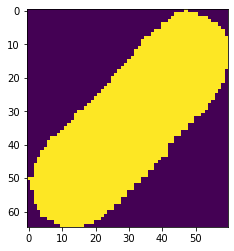

   Shape:
   id 1554



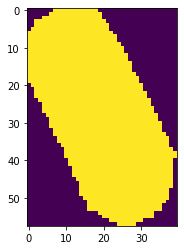

   Shape:
   id 1555



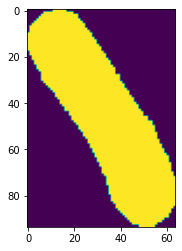

   Shape:
   id 1556



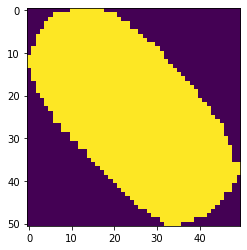

   Shape:
   id 1557



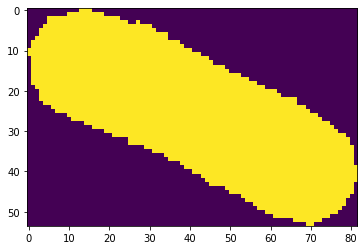

   Shape:
   id 1558



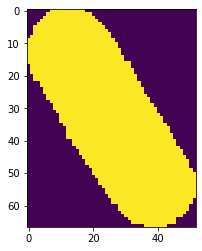

   Shape:
   id 1559



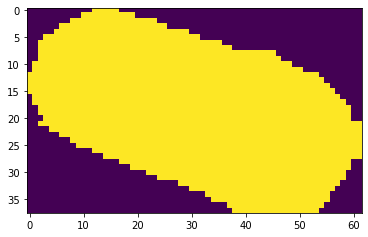

   Shape:
   id 1560



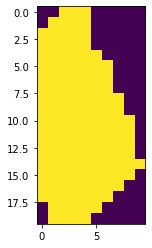

   Shape:
   id 1561



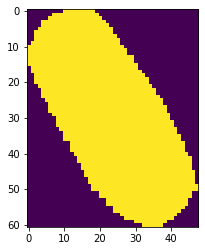

   Shape:
   id 1562



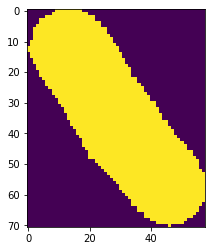

   Shape:
   id 1563



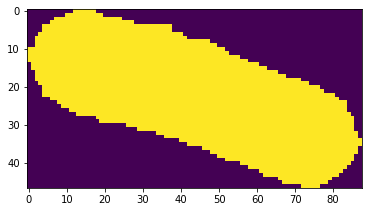

   Shape:
   id 1564



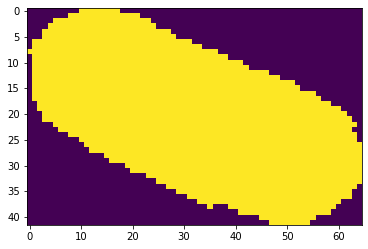

   Shape:
   id 1565



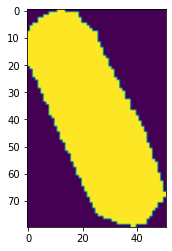

   Shape:
   id 1566



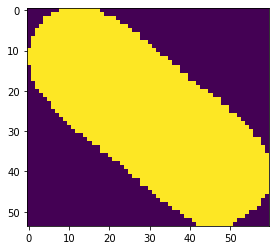

   Shape:
   id 1567



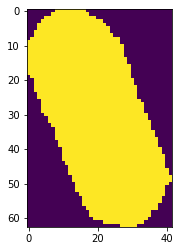

   Shape:
   id 1568



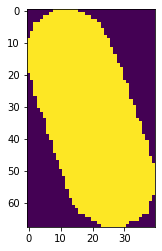

   Shape:
   id 1569



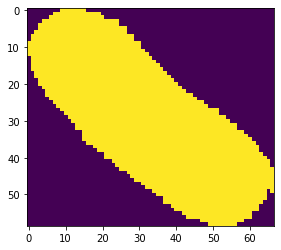

   Shape:
   id 1570



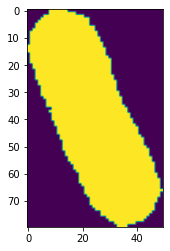

   Shape:
   id 1571



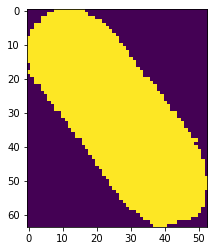

   Shape:
   id 1572



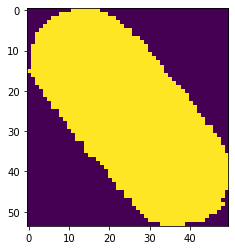

   Shape:
   id 1573



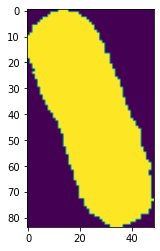

   Shape:
   id 1574



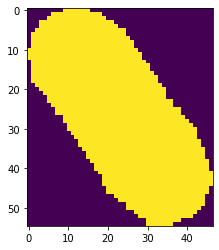

   Shape:
   id 1575



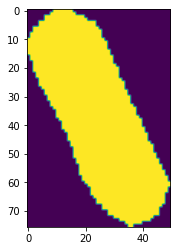

   Shape:
   id 1576



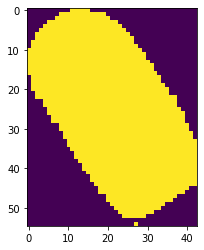

   Shape:
   id 1577



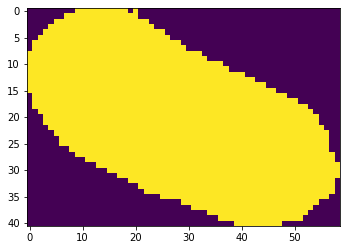

   Shape:
   id 1578



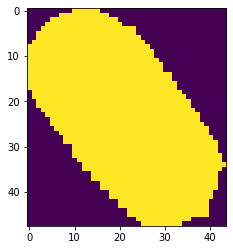

   Shape:
   id 1579



   Shape:
   id 1580



   Shape:
   id 1581



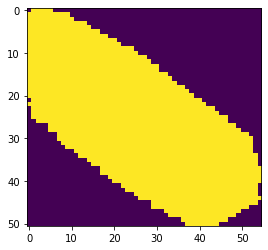

   Shape:
   id 1582



   Shape:
   id 1583



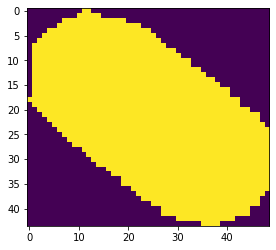

   Shape:
   id 1584



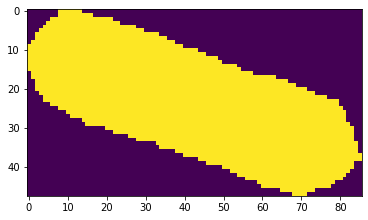

   Shape:
   id 1585



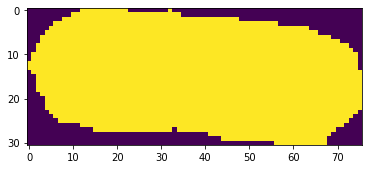

   Shape:
   id 1586



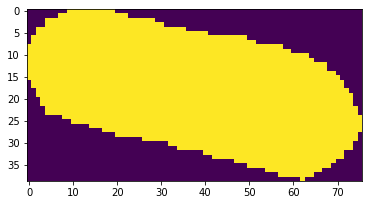

   Shape:
   id 1587



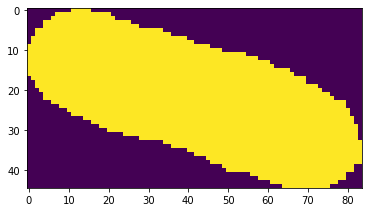

   Shape:
   id 1588



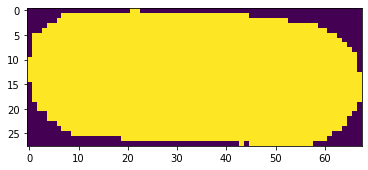

   Shape:
   id 1589



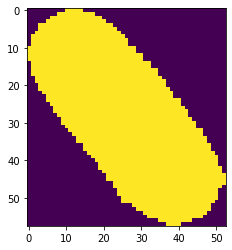

   Shape:
   id 1590



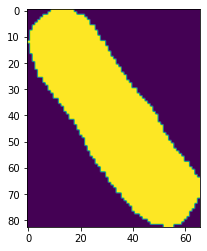

   Shape:
   id 1591



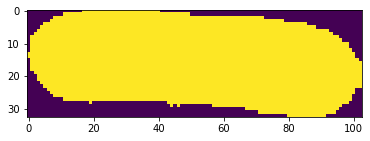

   Shape:
   id 1592



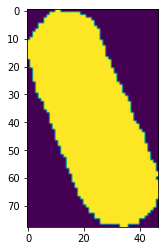

   Shape:
   id 1593



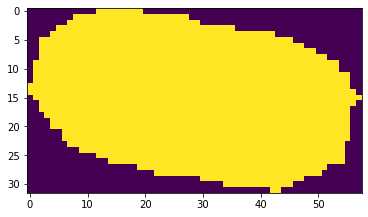

   Shape:
   id 1594



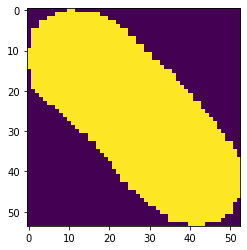

   Shape:
   id 1595



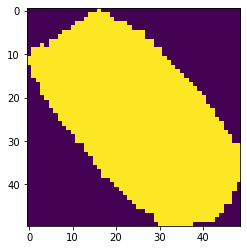

   Shape:
   id 1596



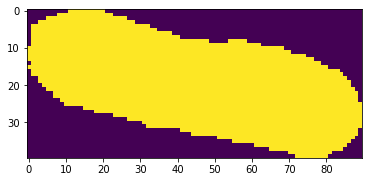

   Shape:
   id 1597



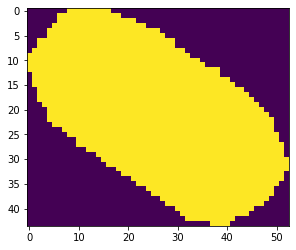

   Shape:
   id 1598



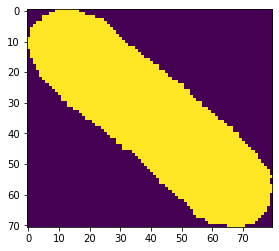

   Shape:
   id 1599



   Shape:
   id 1600



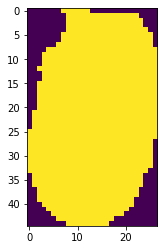

   Shape:
   id 1601



   Shape:
   id 1602



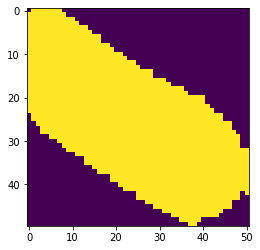

   Shape:
   id 1603



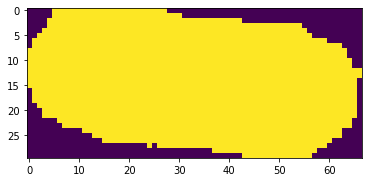

   Shape:
   id 1604



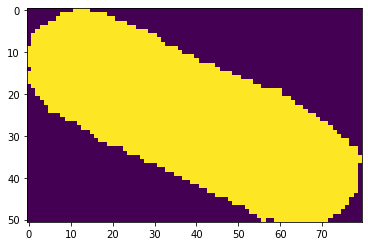

   Shape:
   id 1605



   Shape:
   id 1606



   Shape:
   id 1607



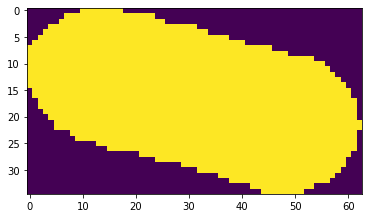

   Shape:
   id 1608



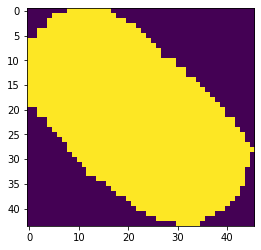

   Shape:
   id 1609



   Shape:
   id 1610



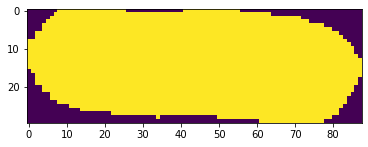

   Shape:
   id 1611



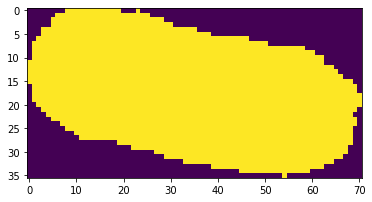

   Shape:
   id 1612



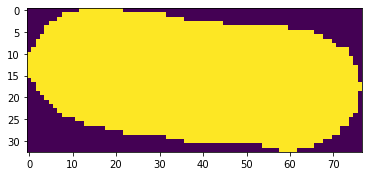

   Shape:
   id 1613



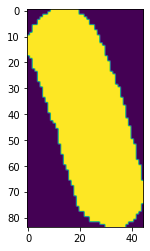

   Shape:
   id 1614



   Shape:
   id 1615



   Shape:
   id 1616



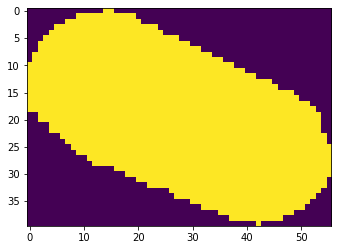

   Shape:
   id 1617



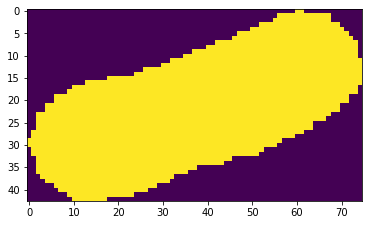

   Shape:
   id 1618



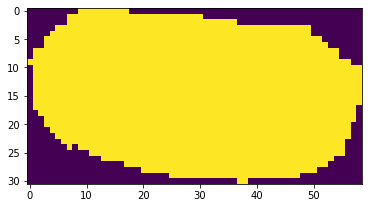

   Shape:
   id 1619



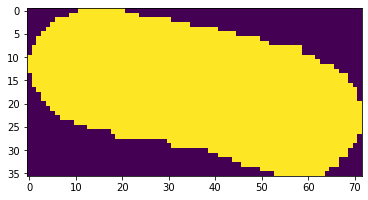

   Shape:
   id 1620



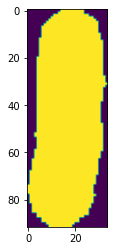

   Shape:
   id 1621



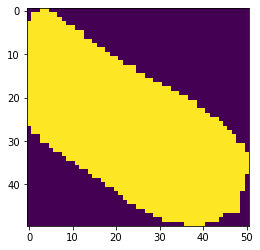

   Shape:
   id 1622



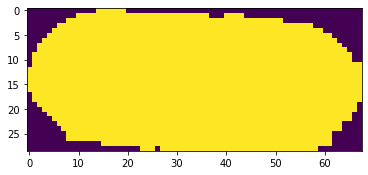

   Shape:
   id 1623



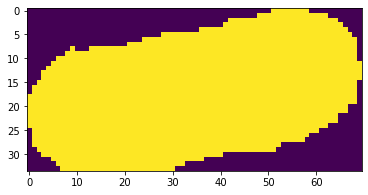

   Shape:
   id 1624



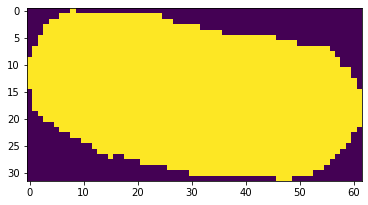

   Shape:
   id 1625



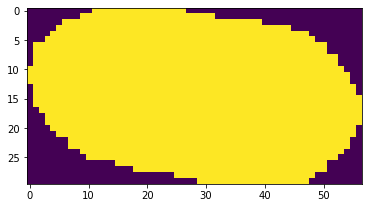

   Shape:
   id 1626



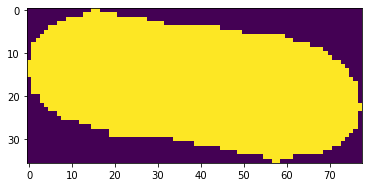

   Shape:
   id 1627



   Shape:
   id 1628



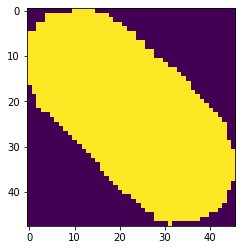

   Shape:
   id 1629



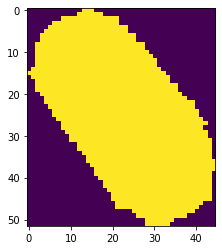

   Shape:
   id 1630



   Shape:
   id 1631



   Shape:
   id 1632



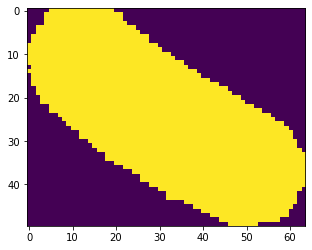

   Shape:
   id 1633



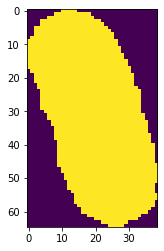

   Shape:
   id 1634



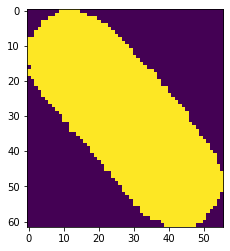

   Shape:
   id 1635



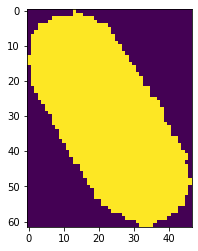

   Shape:
   id 1636



   Shape:
   id 1637



   Shape:
   id 1638



   Shape:
   id 1639



   Shape:
   id 1640



   Shape:
   id 1641



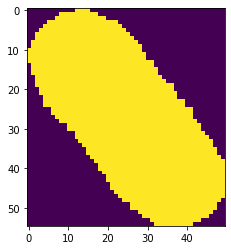

   Shape:
   id 1642



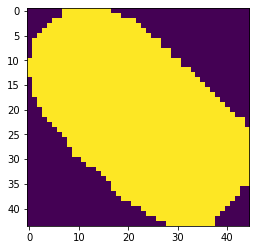

   Shape:
   id 1643



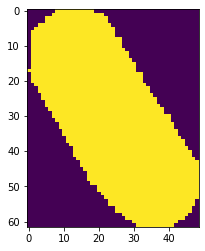

   Shape:
   id 1644



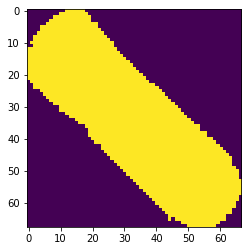

   Shape:
   id 1645



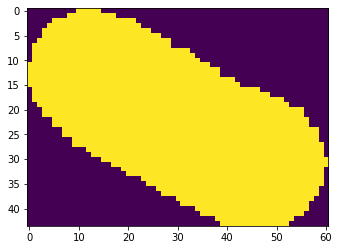

   Shape:
   id 1646



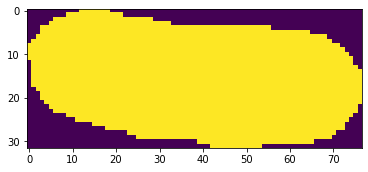

   Shape:
   id 1647



   Shape:
   id 1648



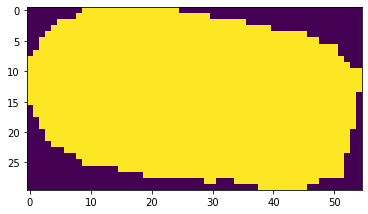

   Shape:
   id 1649



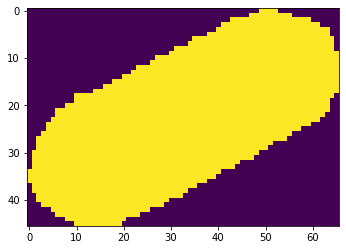

   Shape:
   id 1650



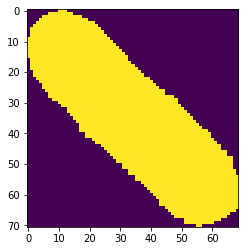

   Shape:
   id 1651



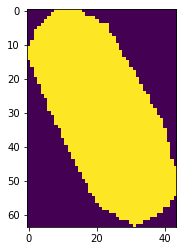

   Shape:
   id 1652



   Shape:
   id 1653



   Shape:
   id 1654



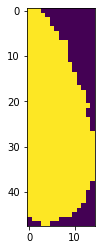

   Shape:
   id 1655



   Shape:
   id 1656



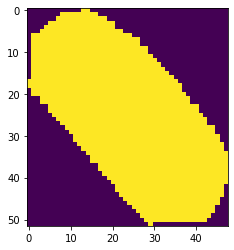

   Shape:
   id 1657



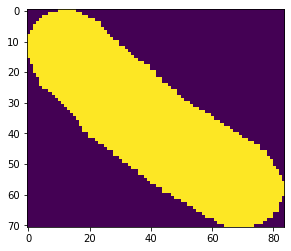

   Shape:
   id 1658



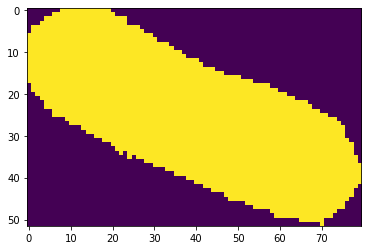

   Shape:
   id 1659



   Shape:
   id 1660



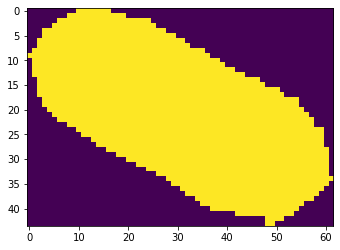

   Shape:
   id 1661



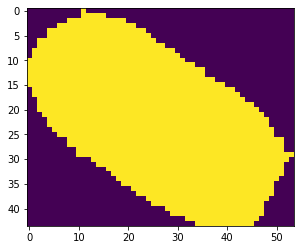

   Shape:
   id 1662



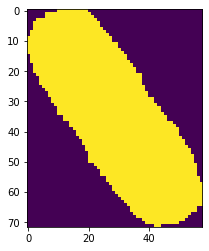

   Shape:
   id 1663



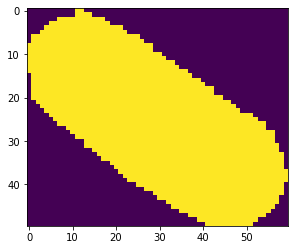

   Shape:
   id 1664



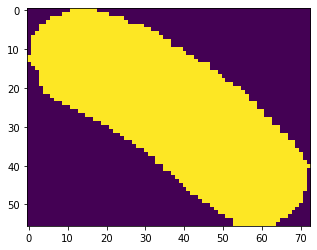

   Shape:
   id 1665



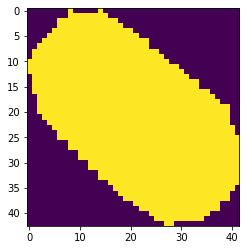

   Shape:
   id 1666



   Shape:
   id 1667



   Shape:
   id 1668



   Shape:
   id 1669



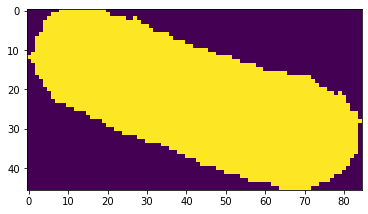

   Shape:
   id 1670



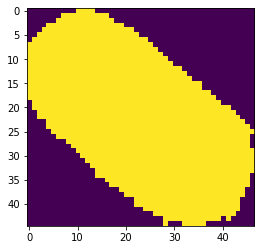

   Shape:
   id 1671



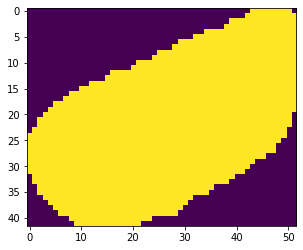

   Shape:
   id 1672



   Shape:
   id 1673



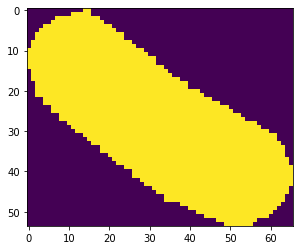

   Shape:
   id 1674



   Shape:
   id 1675



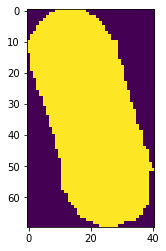

   Shape:
   id 1676



   Shape:
   id 1677



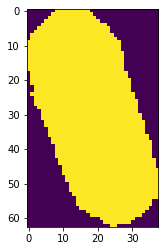

   Shape:
   id 1678



   Shape:
   id 1679



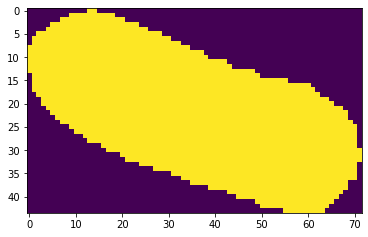

   Shape:
   id 1680



   Shape:
   id 1681



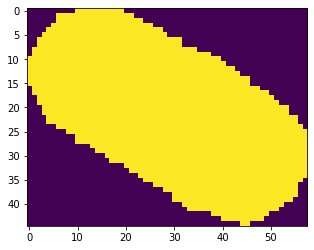

   Shape:
   id 1682



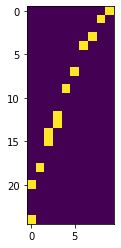

   Shape:
   id 1683



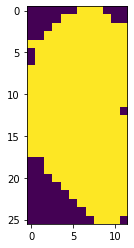

   Shape:
   id 1684



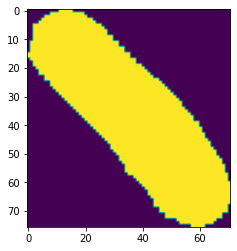

   Shape:
   id 1685



   Shape:
   id 1686



   Shape:
   id 1687



   Shape:
   id 1688



   Shape:
   id 1689



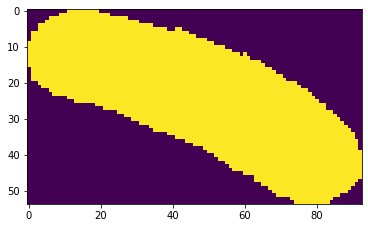

   Shape:
   id 1690



   Shape:
   id 1691



   Shape:
   id 1692



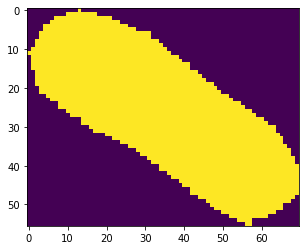

   Shape:
   id 1693



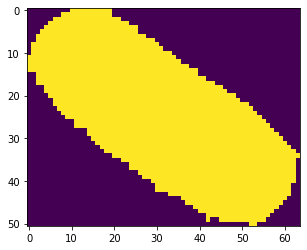

   Shape:
   id 1694



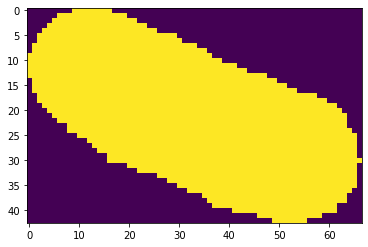

   Shape:
   id 1695



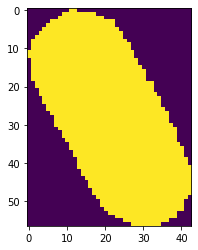

   Shape:
   id 1696



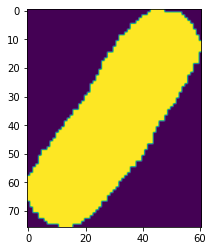

   Shape:
   id 1697



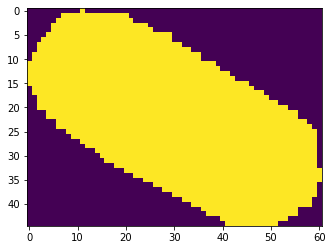

   Shape:
   id 1698



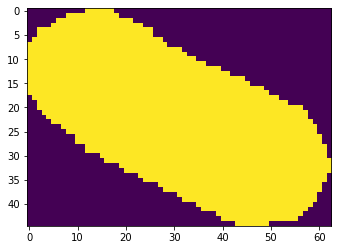

   Shape:
   id 1699



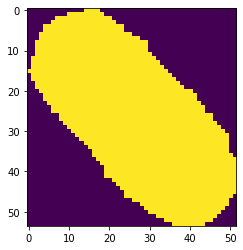

   Shape:
   id 1700



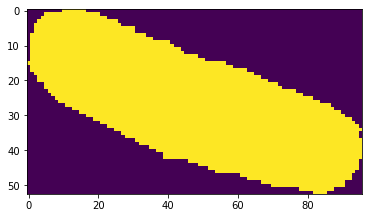

   Shape:
   id 1701



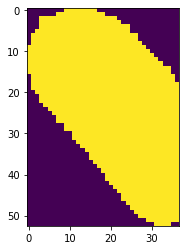

   Shape:
   id 1702



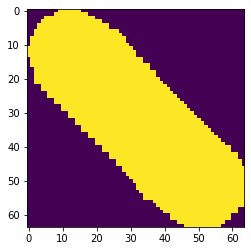

   Shape:
   id 1703



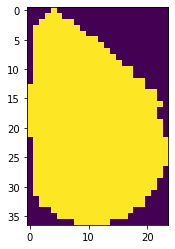

   Shape:
   id 1704



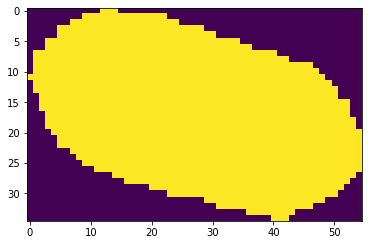

   Shape:
   id 1705



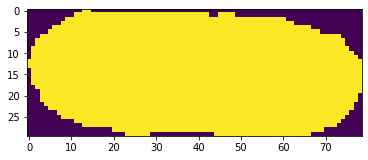

   Shape:
   id 1706



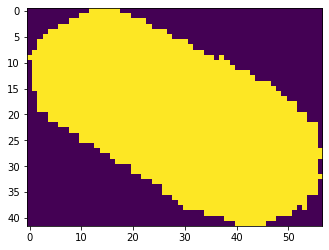

   Shape:
   id 1707



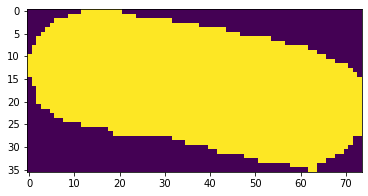

   Shape:
   id 1708



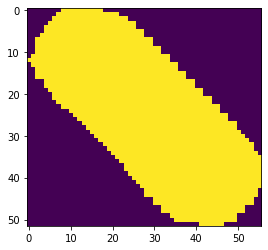

   Shape:
   id 1709



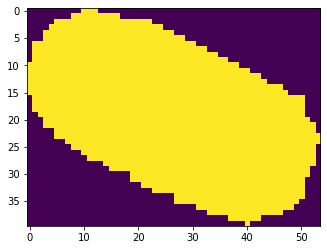

   Shape:
   id 1710



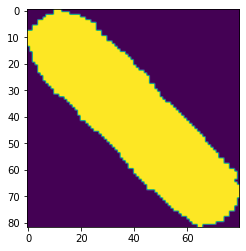

   Shape:
   id 1711



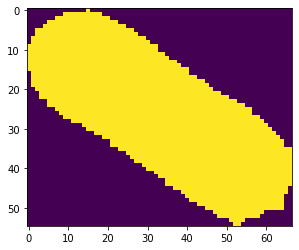

   Shape:
   id 1712



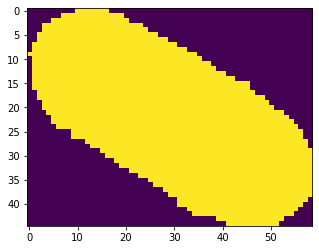

   Shape:
   id 1713



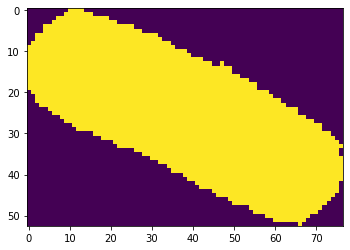

   Shape:
   id 1714



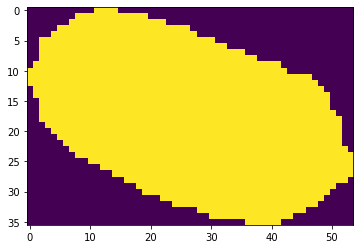

   Shape:
   id 1715



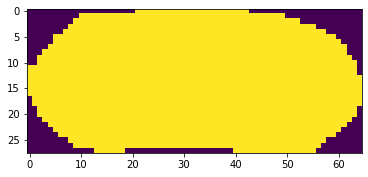

   Shape:
   id 1716



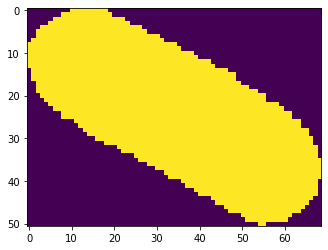

   Shape:
   id 1717



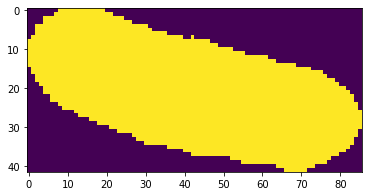

   Shape:
   id 1718



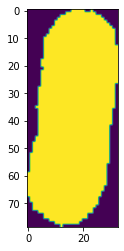

   Shape:
   id 1719



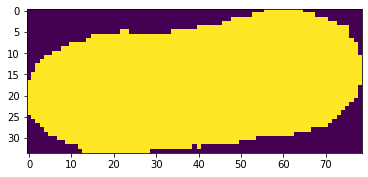

   Shape:
   id 1720



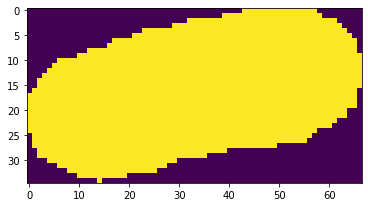

   Shape:
   id 1721



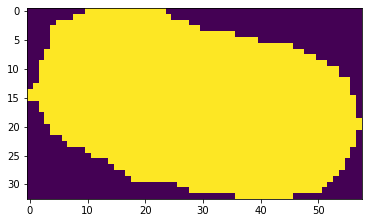

   Shape:
   id 1722



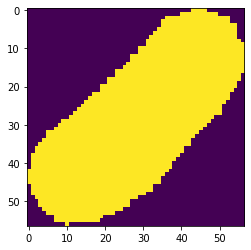

   Shape:
   id 1723



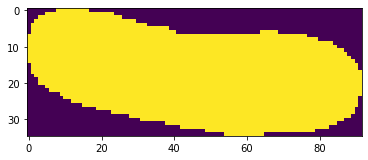

   Shape:
   id 1724



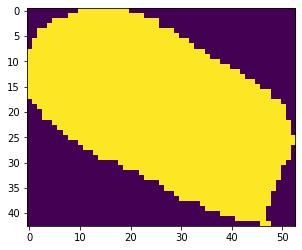

   Shape:
   id 1725



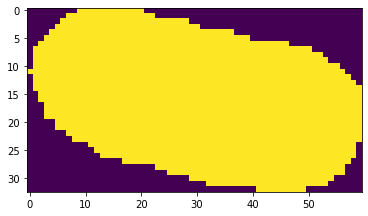

   Shape:
   id 1726



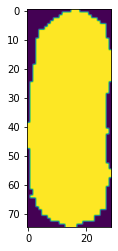

   Shape:
   id 1727



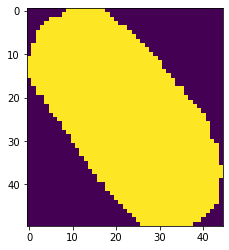

   Shape:
   id 1728



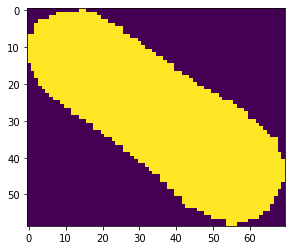

   Shape:
   id 1729



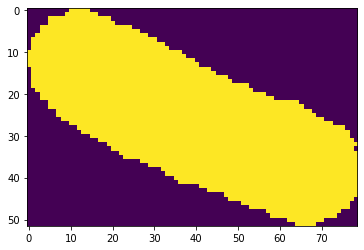

   Shape:
   id 1730



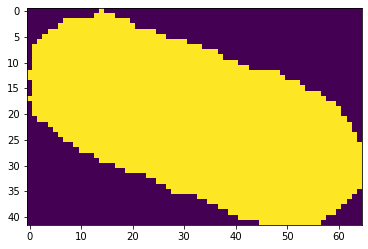

   Shape:
   id 1731



   Shape:
   id 1732



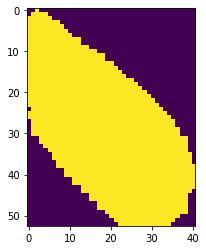

   Shape:
   id 1733



   Shape:
   id 1734



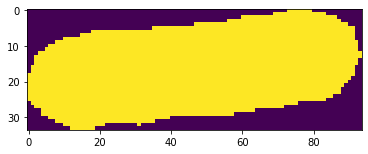

   Shape:
   id 1735



   Shape:
   id 1736



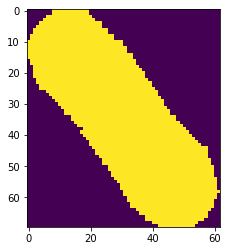

   Shape:
   id 1737



   Shape:
   id 1738



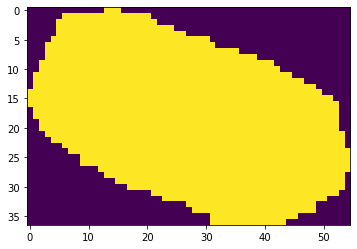

   Shape:
   id 1739



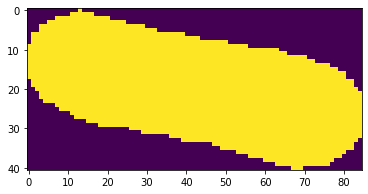

   Shape:
   id 1740



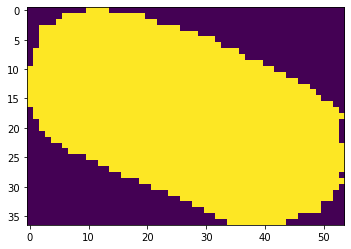

   Shape:
   id 1741



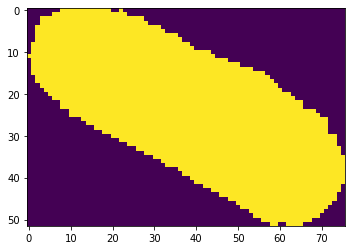

   Shape:
   id 1742



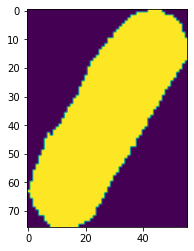

   Shape:
   id 1743



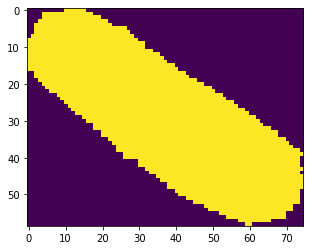

   Shape:
   id 1744



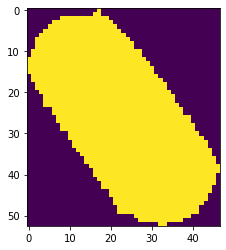

   Shape:
   id 1745



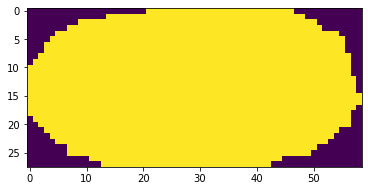

   Shape:
   id 1746



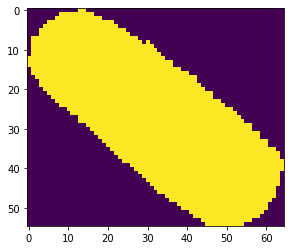

   Shape:
   id 1747



   Shape:
   id 1748



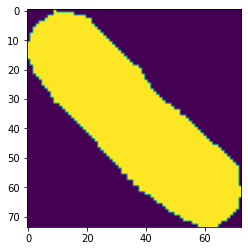

   Shape:
   id 1749



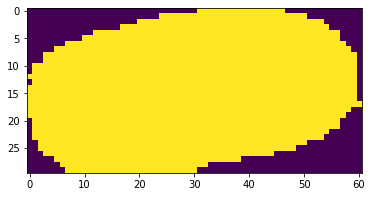

   Shape:
   id 1750



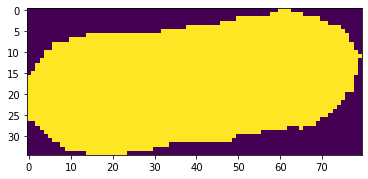

   Shape:
   id 1751



   Shape:
   id 1752



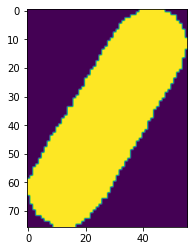

   Shape:
   id 1753



   Shape:
   id 1754



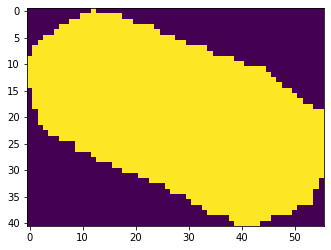

   Shape:
   id 1755



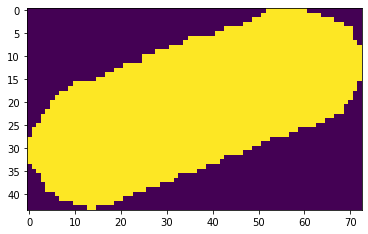

   Shape:
   id 1756



   Shape:
   id 1757



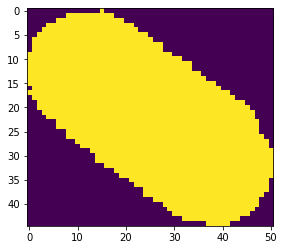

   Shape:
   id 1758



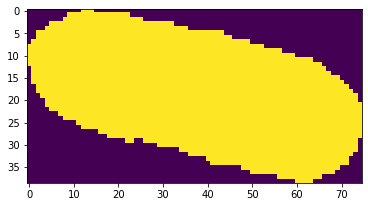

   Shape:
   id 1759



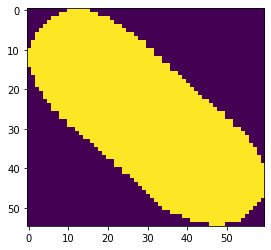

   Shape:
   id 1760



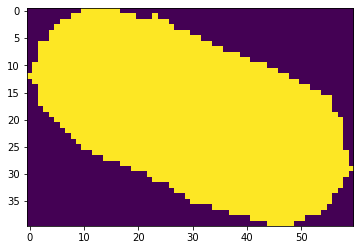

   Shape:
   id 1761



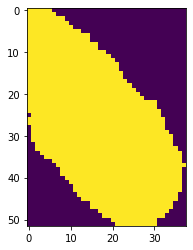

   Shape:
   id 1762



   Shape:
   id 1763



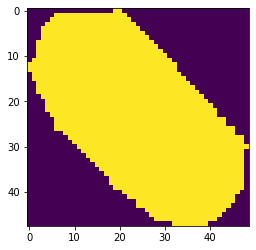

   Shape:
   id 1764



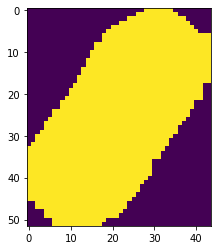

   Shape:
   id 1765



   Shape:
   id 1766



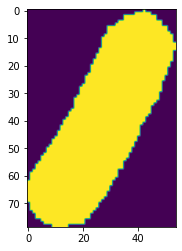

   Shape:
   id 1767



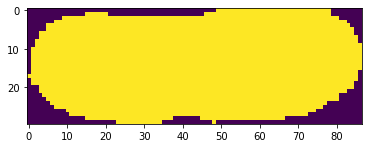

   Shape:
   id 1768



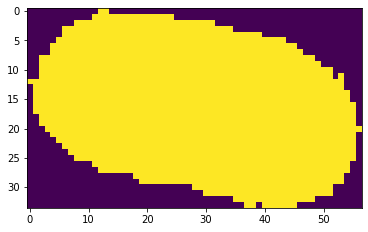

   Shape:
   id 1769



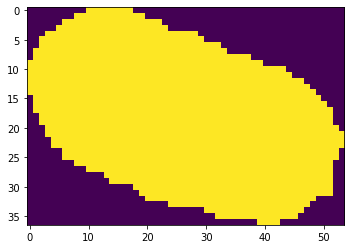

   Shape:
   id 1770



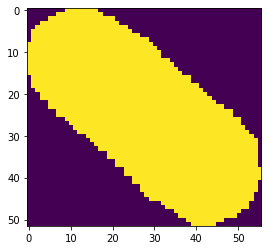

   Shape:
   id 1771



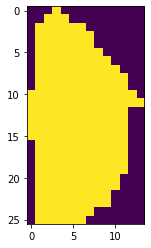

   Shape:
   id 1772



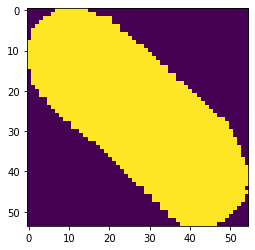

   Shape:
   id 1773



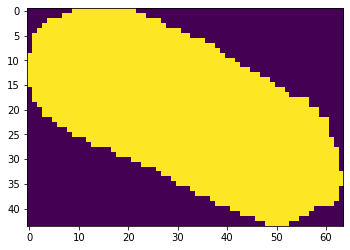

   Shape:
   id 1774



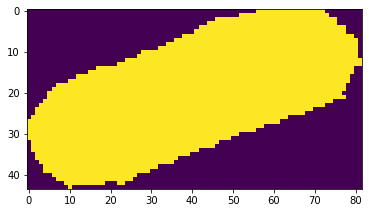

   Shape:
   id 1775



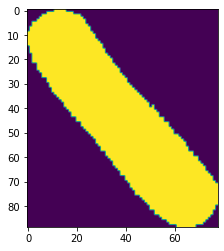

   Shape:
   id 1776



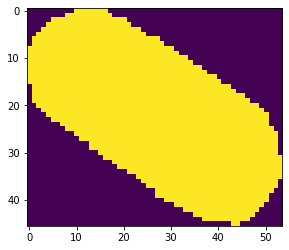

   Shape:
   id 1777



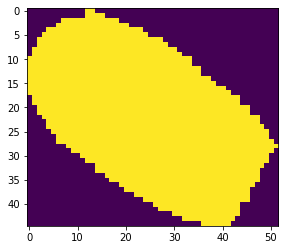

   Shape:
   id 1778



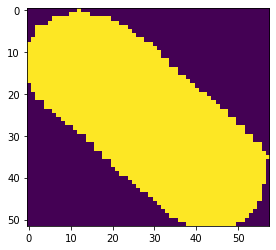

   Shape:
   id 1779



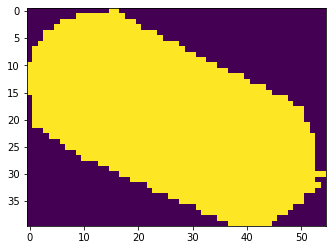

   Shape:
   id 1780



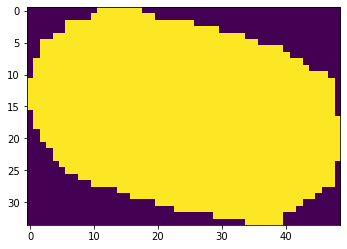

   Shape:
   id 1781



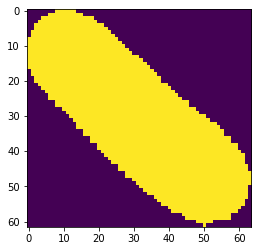

   Shape:
   id 1782



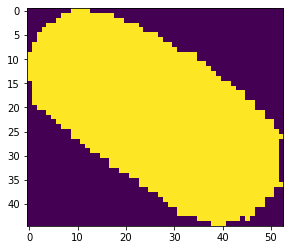

   Shape:
   id 1783



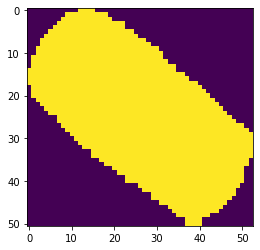

   Shape:
   id 1784



   Shape:
   id 1785



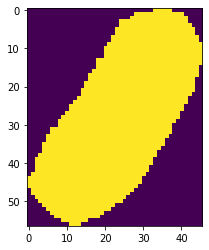

   Shape:
   id 1786



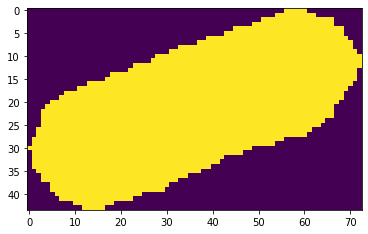

   Shape:
   id 1787



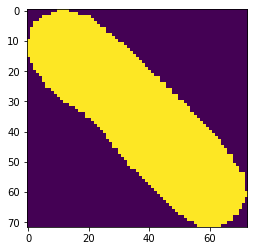

   Shape:
   id 1788



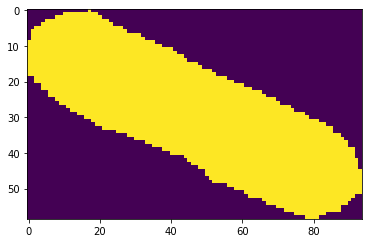

   Shape:
   id 1789



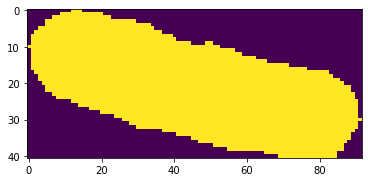

   Shape:
   id 1790



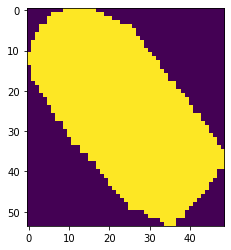

   Shape:
   id 1791



   Shape:
   id 1792



   Shape:
   id 1793



   Shape:
   id 1794



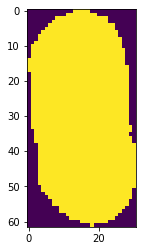

   Shape:
   id 1795



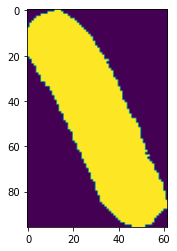

   Shape:
   id 1796



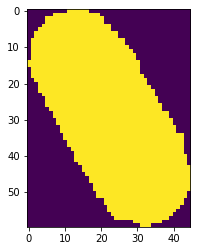

   Shape:
   id 1797



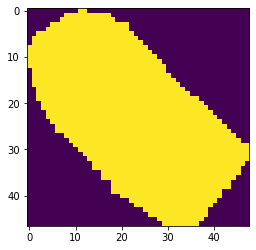

   Shape:
   id 1798



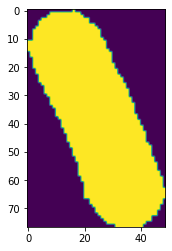

   Shape:
   id 1799



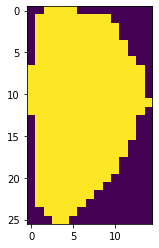

   Shape:
   id 1800



   Shape:
   id 1801



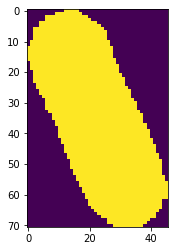

   Shape:
   id 1802



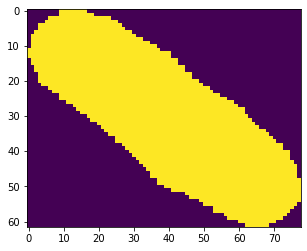

   Shape:
   id 1803



   Shape:
   id 1804



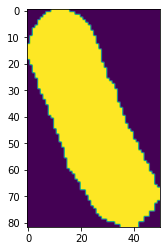

   Shape:
   id 1805



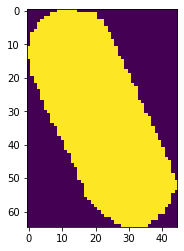

   Shape:
   id 1806



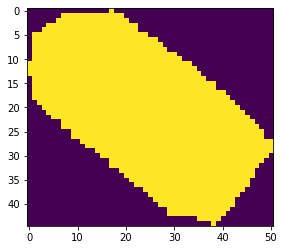

   Shape:
   id 1807



   Shape:
   id 1808



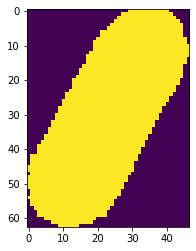

   Shape:
   id 1809



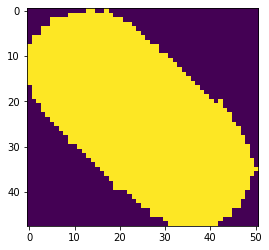

   Shape:
   id 1810



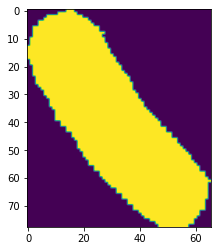

   Shape:
   id 1811



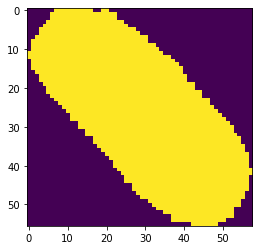

   Shape:
   id 1812



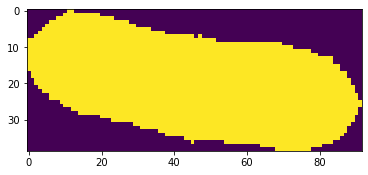

   Shape:
   id 1813



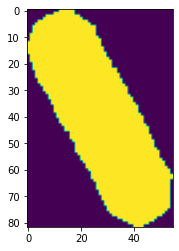

   Shape:
   id 1814



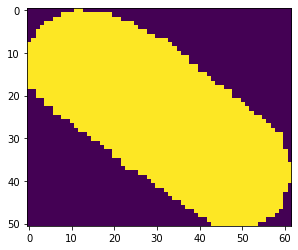

   Shape:
   id 1815



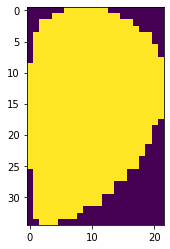

   Shape:
   id 1816



   Shape:
   id 1817



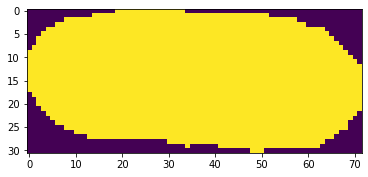

   Shape:
   id 1818



   Shape:
   id 1819



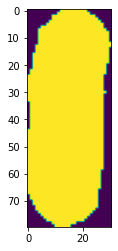

   Shape:
   id 1820



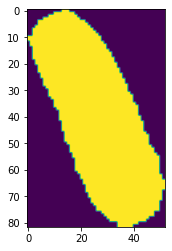

   Shape:
   id 1821



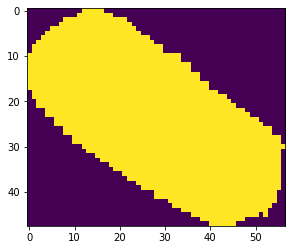

   Shape:
   id 1822



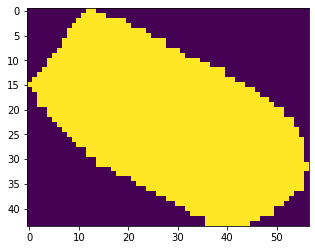

   Shape:
   id 1823



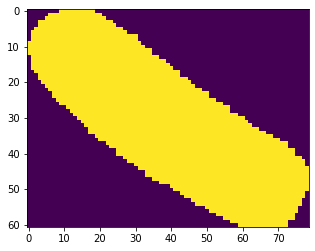

   Shape:
   id 1824



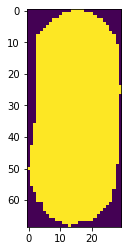

   Shape:
   id 1825



   Shape:
   id 1826



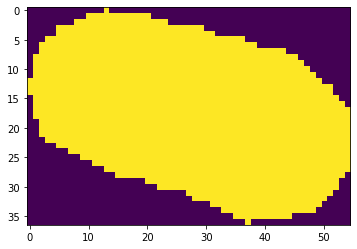

   Shape:
   id 1827



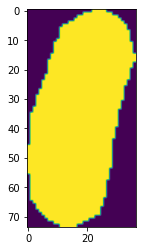

   Shape:
   id 1828



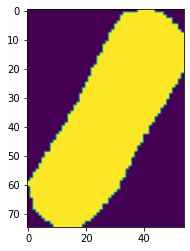

   Shape:
   id 1829



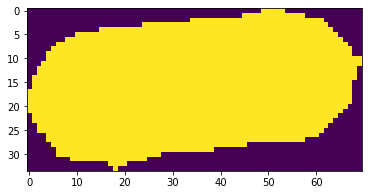

   Shape:
   id 1830



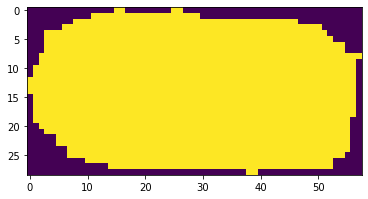

   Shape:
   id 1831



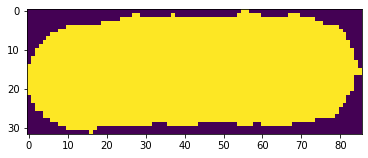

   Shape:
   id 1832



   Shape:
   id 1833



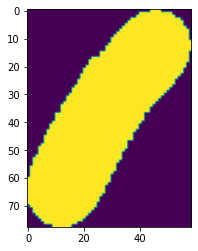

   Shape:
   id 1834



   Shape:
   id 1835



   Shape:
   id 1836



   Shape:
   id 1837



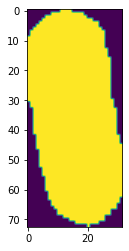

   Shape:
   id 1838



   Shape:
   id 1839



   Shape:
   id 1840



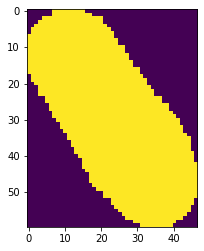

   Shape:
   id 1841



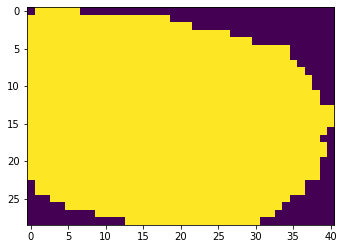

   Shape:
   id 1842



   Shape:
   id 1843



   Shape:
   id 1844



   Shape:
   id 1845



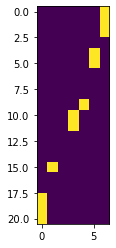

   Shape:
   id 1846



   Shape:
   id 1847



   Shape:
   id 1848



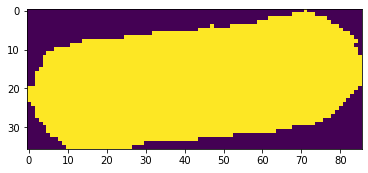

   Shape:
   id 1849



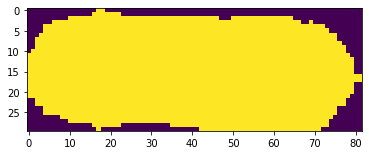

   Shape:
   id 1850



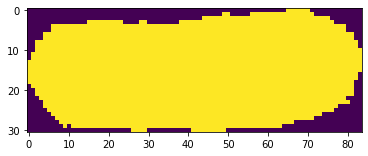

   Shape:
   id 1851



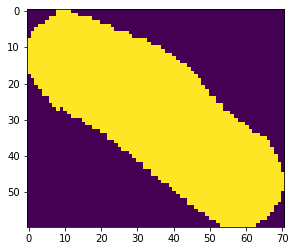

   Shape:
   id 1852



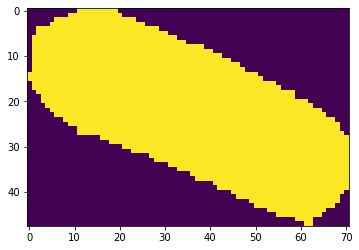

   Shape:
   id 1853



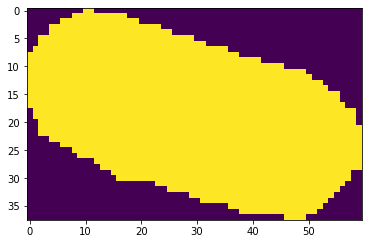

   Shape:
   id 1854



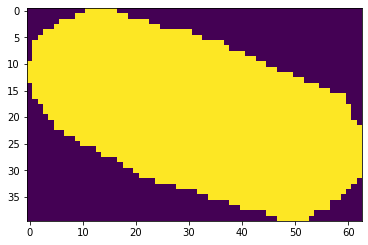

   Shape:
   id 1855



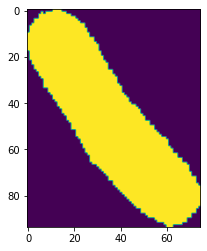

   Shape:
   id 1856



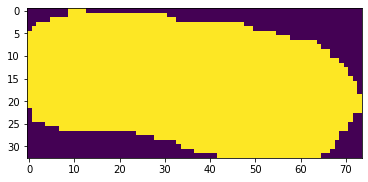

   Shape:
   id 1857



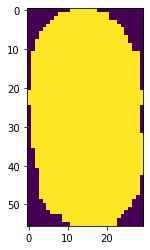

   Shape:
   id 1858



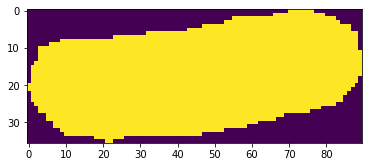

   Shape:
   id 1859



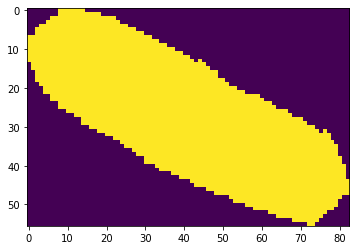

   Shape:
   id 1860



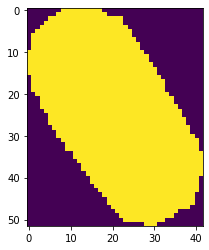

   Shape:
   id 1861



   Shape:
   id 1862



   Shape:
   id 1863



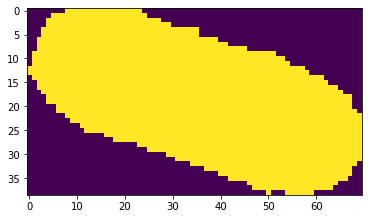

   Shape:
   id 1864



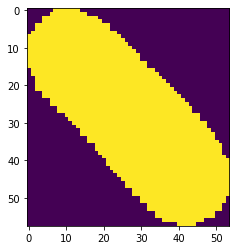

   Shape:
   id 1865



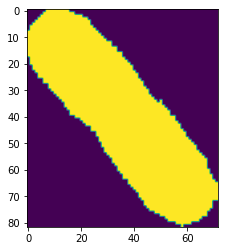

   Shape:
   id 1866



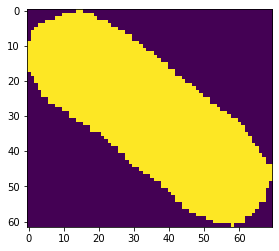

   Shape:
   id 1867



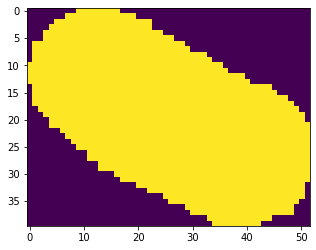

   Shape:
   id 1868



   Shape:
   id 1869



   Shape:
   id 1870



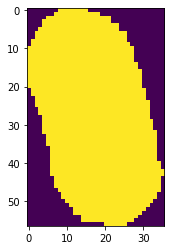

   Shape:
   id 1871



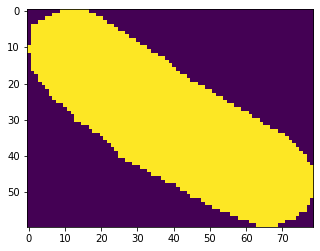

   Shape:
   id 1872



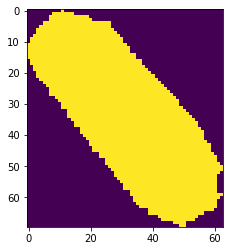

   Shape:
   id 1873



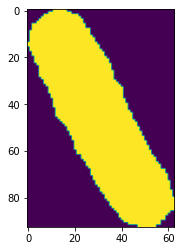

   Shape:
   id 1874



   Shape:
   id 1875



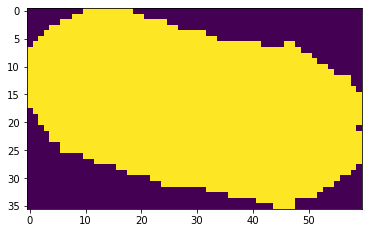

   Shape:
   id 1876



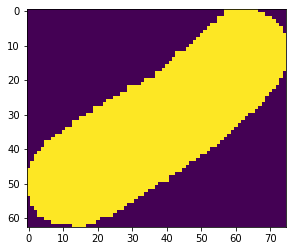

   Shape:
   id 1877



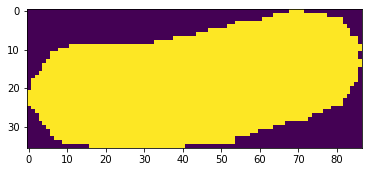

   Shape:
   id 1878



   Shape:
   id 1879



   Shape:
   id 1880



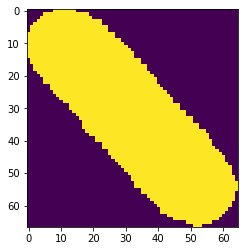

   Shape:
   id 1881



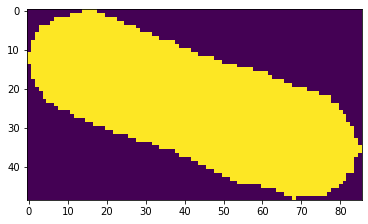

   Shape:
   id 1882



   Shape:
   id 1883



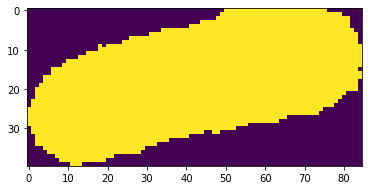

   Shape:
   id 1884



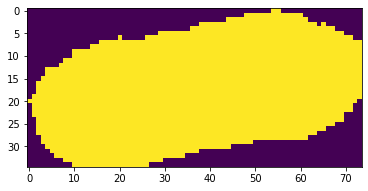

   Shape:
   id 1885



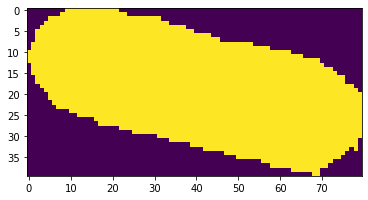

   Shape:
   id 1886



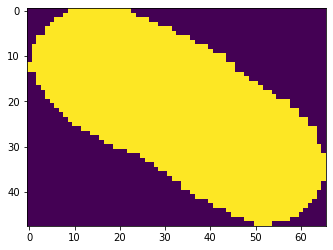

   Shape:
   id 1887



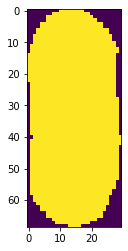

   Shape:
   id 1888



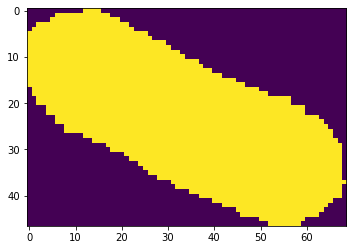

   Shape:
   id 1889



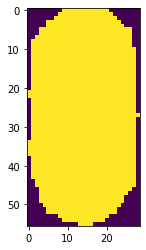

   Shape:
   id 1890



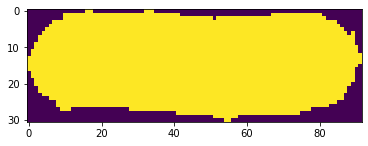

   Shape:
   id 1891



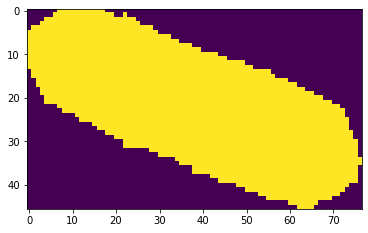

   Shape:
   id 1892



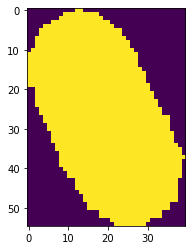

   Shape:
   id 1893



   Shape:
   id 1894



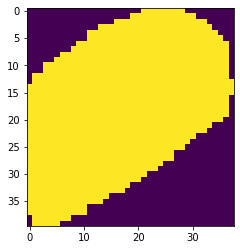

   Shape:
   id 1895



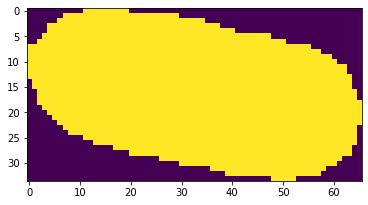

   Shape:
   id 1896



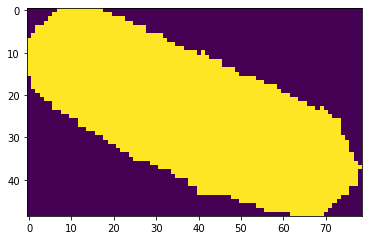

   Shape:
   id 1897



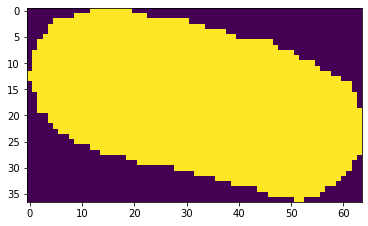

   Shape:
   id 1898



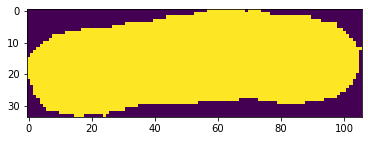

   Shape:
   id 1899



   Shape:
   id 1900



   Shape:
   id 1901



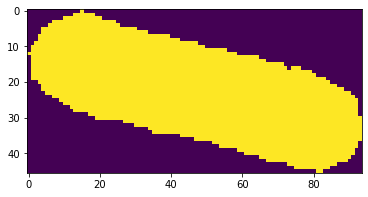

   Shape:
   id 1902



   Shape:
   id 1903



   Shape:
   id 1904



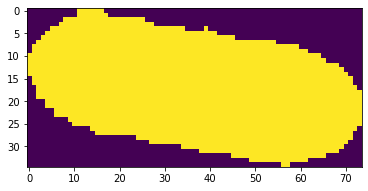

   Shape:
   id 1905



   Shape:
   id 1906



   Shape:
   id 1907



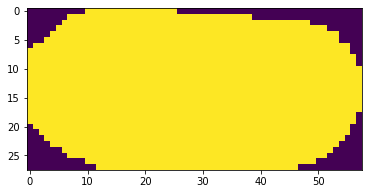

   Shape:
   id 1908



   Shape:
   id 1909



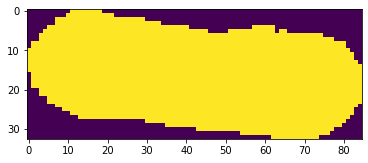

   Shape:
   id 1910



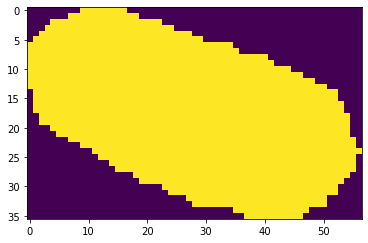

   Shape:
   id 1911



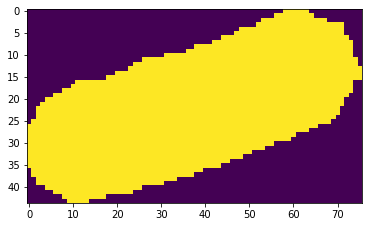

   Shape:
   id 1912



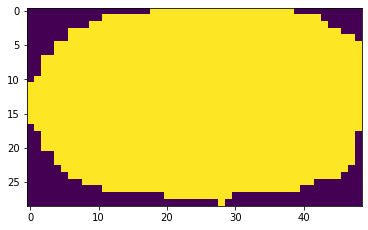

   Shape:
   id 1913



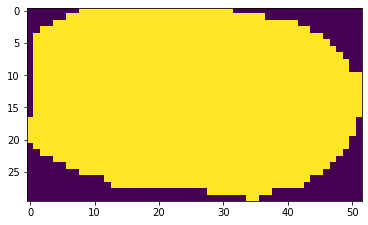

   Shape:
   id 1914



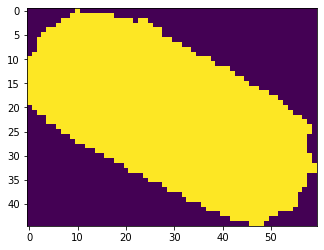

   Shape:
   id 1915



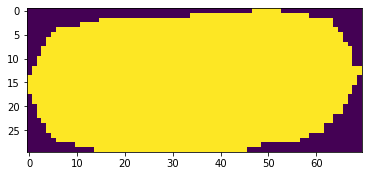

   Shape:
   id 1916



   Shape:
   id 1917



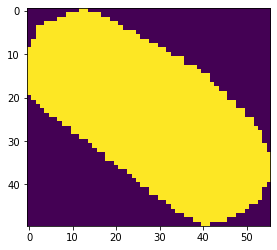

   Shape:
   id 1918



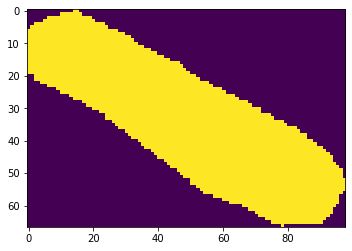

   Shape:
   id 1919



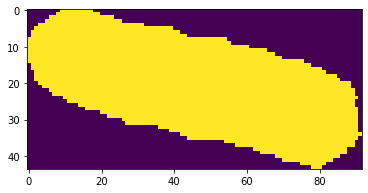

   Shape:
   id 1920



   Shape:
   id 1921



   Shape:
   id 1922



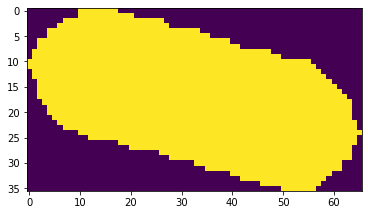

   Shape:
   id 1923



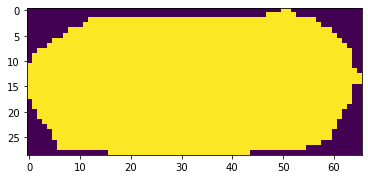

   Shape:
   id 1924



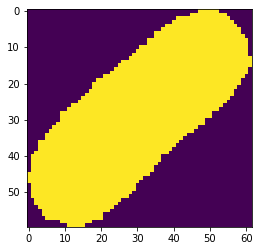

   Shape:
   id 1925



   Shape:
   id 1926



   Shape:
   id 1927



   Shape:
   id 1928



   Shape:
   id 1929



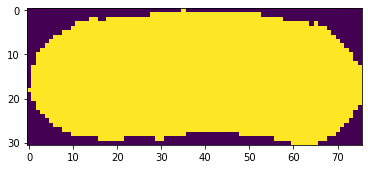

   Shape:
   id 1930



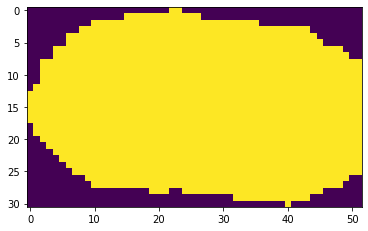

   Shape:
   id 1931



   Shape:
   id 1932



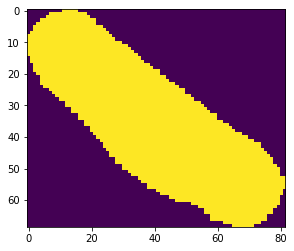

   Shape:
   id 1933



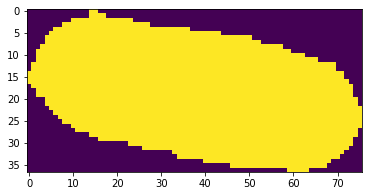

   Shape:
   id 1934



   Shape:
   id 1935



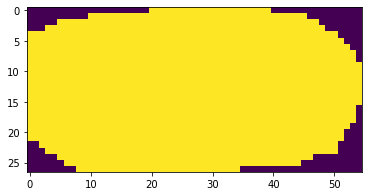

   Shape:
   id 1936



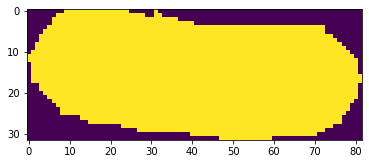

   Shape:
   id 1937



   Shape:
   id 1938



   Shape:
   id 1939



   Shape:
   id 1940



   Shape:
   id 1941



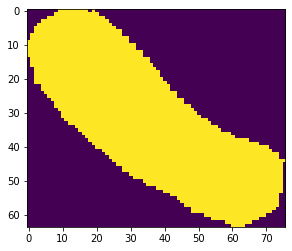

   Shape:
   id 1942



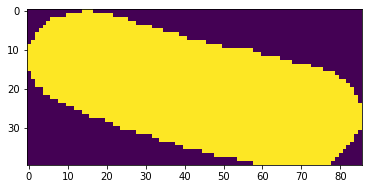

   Shape:
   id 1943



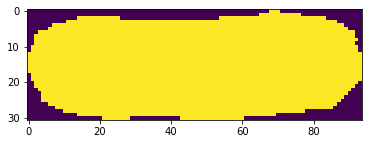

   Shape:
   id 1944



   Shape:
   id 1945



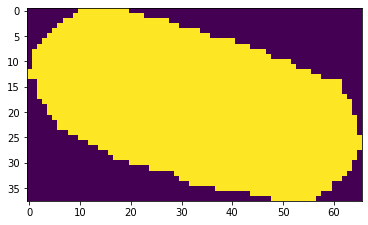

   Shape:
   id 1946



   Shape:
   id 1947



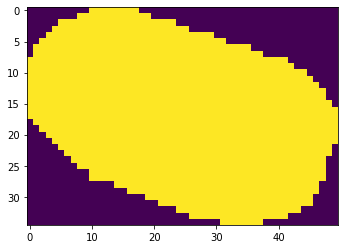

   Shape:
   id 1948



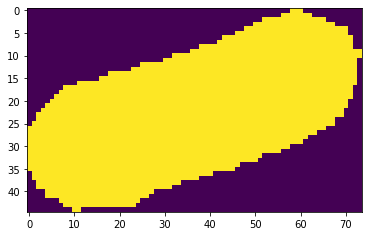

   Shape:
   id 1949



   Shape:
   id 1950



   Shape:
   id 1951



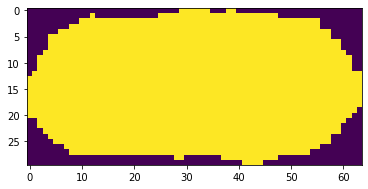

   Shape:
   id 1952



   Shape:
   id 1953



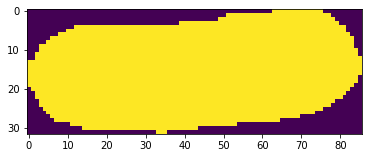

   Shape:
   id 1954



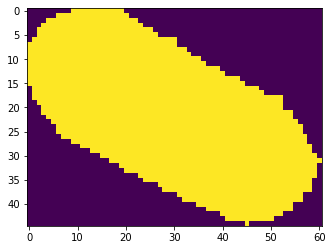

   Shape:
   id 1955



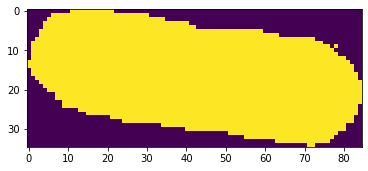

   Shape:
   id 1956



   Shape:
   id 1957



   Shape:
   id 1958



   Shape:
   id 1959



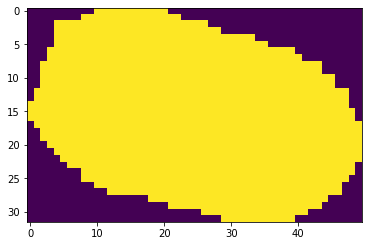

   Shape:
   id 1960



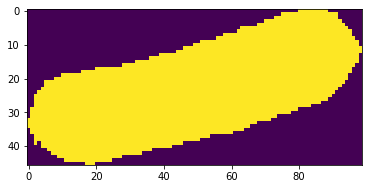

   Shape:
   id 1961



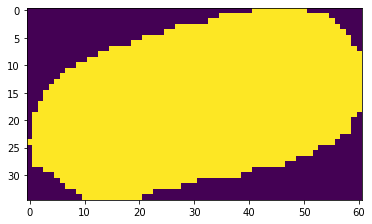

   Shape:
   id 1962



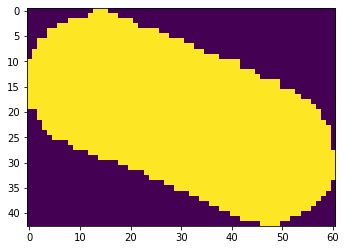

   Shape:
   id 1963



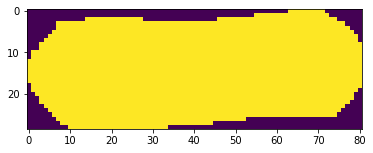

   Shape:
   id 1964



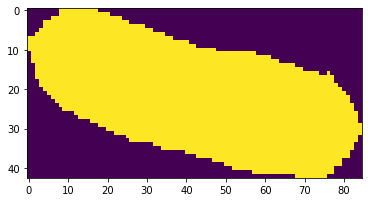

   Shape:
   id 1965



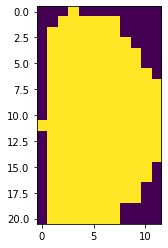

   Shape:
   id 1966



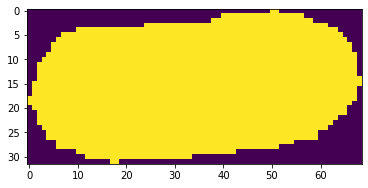

   Shape:
   id 1967



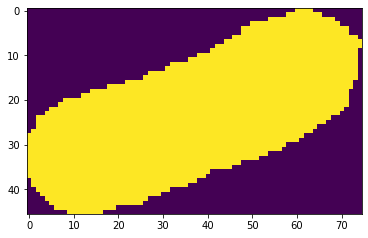

   Shape:
   id 1968



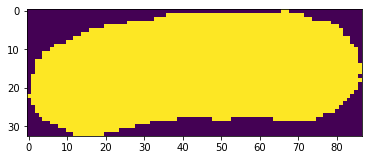

   Shape:
   id 1969



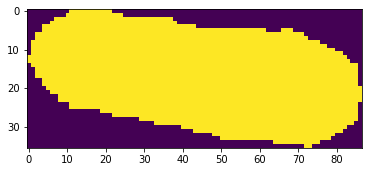

   Shape:
   id 1970



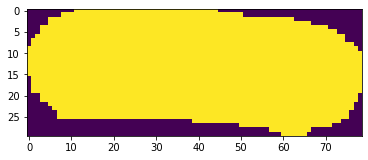

   Shape:
   id 1971



   Shape:
   id 1972



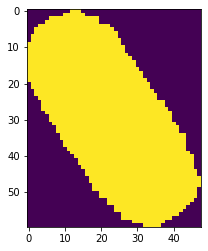

   Shape:
   id 1973



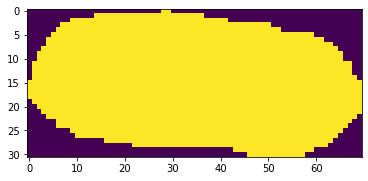

   Shape:
   id 1974



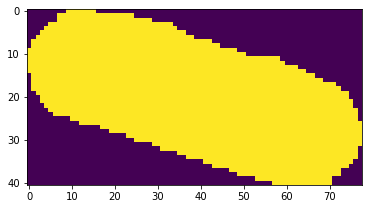

   Shape:
   id 1975



   Shape:
   id 1976



   Shape:
   id 1977



   Shape:
   id 1978



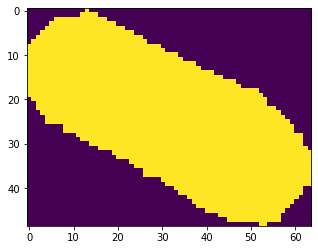

   Shape:
   id 1979



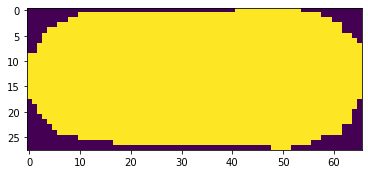

   Shape:
   id 1980



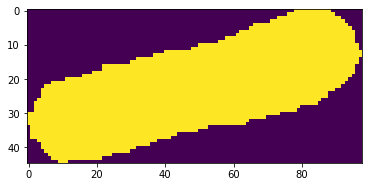

   Shape:
   id 1981



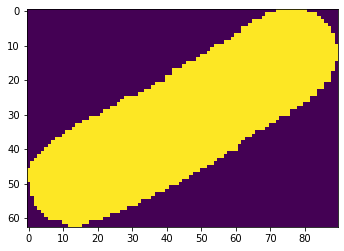

   Shape:
   id 1982



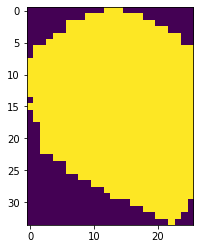

   Shape:
   id 1983



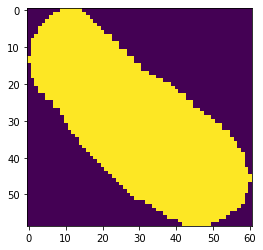

   Shape:
   id 1984



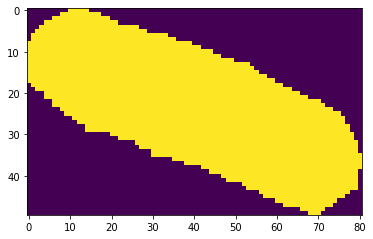

   Shape:
   id 1985



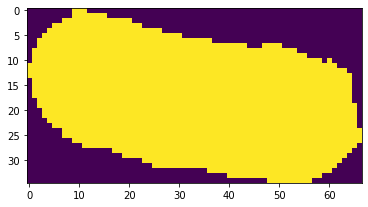

   Shape:
   id 1986



   Shape:
   id 1987



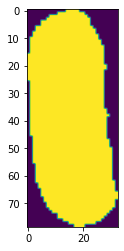

   Shape:
   id 1988



   Shape:
   id 1989



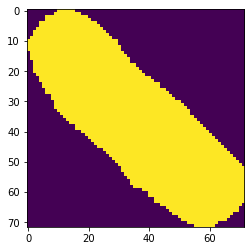

   Shape:
   id 1990



   Shape:
   id 1991



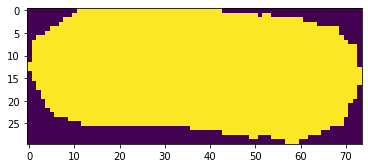

   Shape:
   id 1992



   Shape:
   id 1993



   Shape:
   id 1994



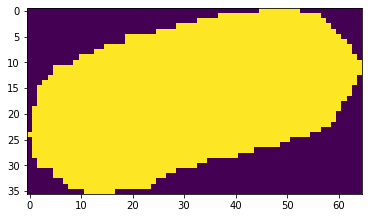

   Shape:
   id 1995



   Shape:
   id 1996



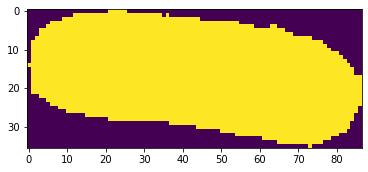

   Shape:
   id 1997



   Shape:
   id 1998



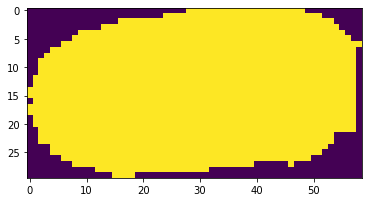

   Shape:
   id 1999



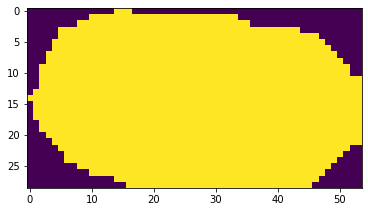

   Shape:
   id 2000



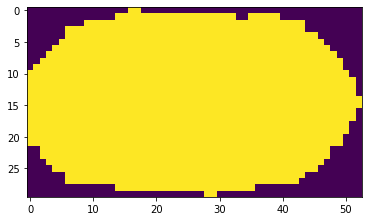

   Shape:
   id 2001



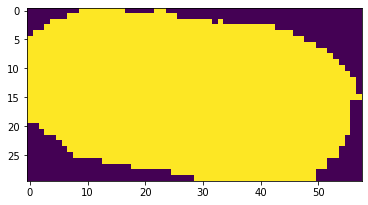

   Shape:
   id 2002



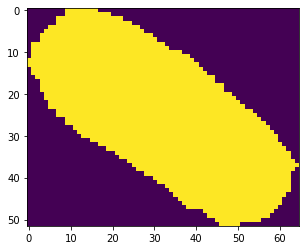

   Shape:
   id 2003



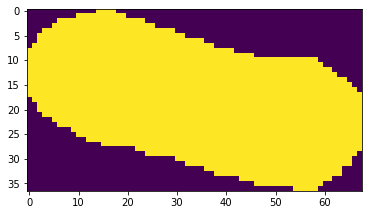

   Shape:
   id 2004



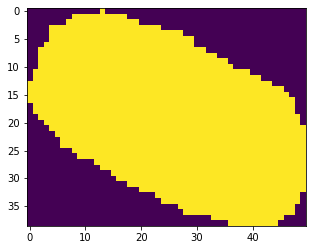

   Shape:
   id 2005



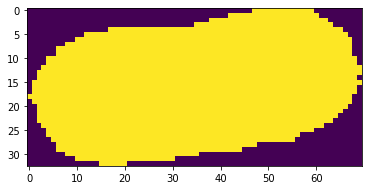

   Shape:
   id 2006



   Shape:
   id 2007



   Shape:
   id 2008



   Shape:
   id 2009



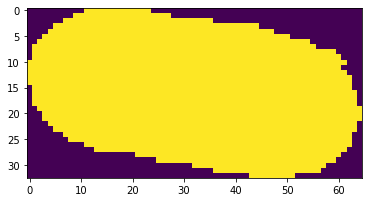

   Shape:
   id 2010



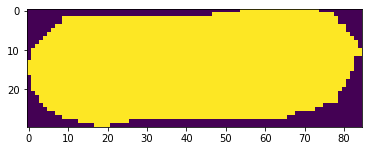

   Shape:
   id 2011



   Shape:
   id 2012



   Shape:
   id 2013



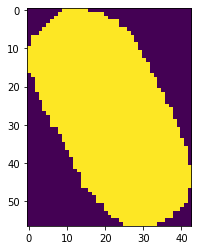

   Shape:
   id 2014



   Shape:
   id 2015



   Shape:
   id 2016



   Shape:
   id 2017



   Shape:
   id 2018



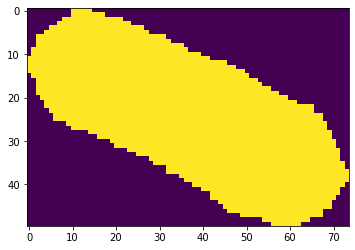

   Shape:
   id 2019



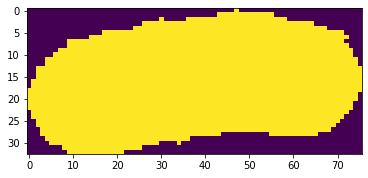

   Shape:
   id 2020



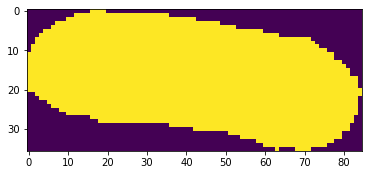

   Shape:
   id 2021



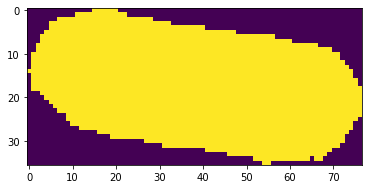

   Shape:
   id 2022



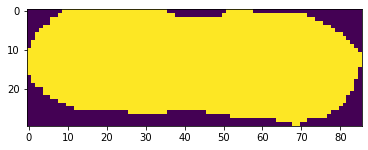

   Shape:
   id 2023



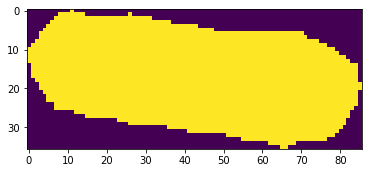

   Shape:
   id 2024



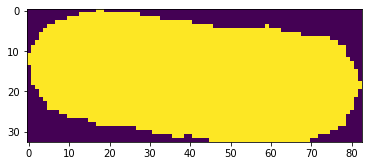

   Shape:
   id 2025



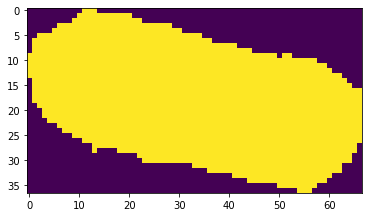

   Shape:
   id 2026



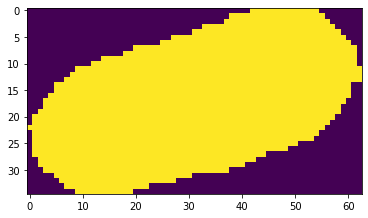

   Shape:
   id 2027



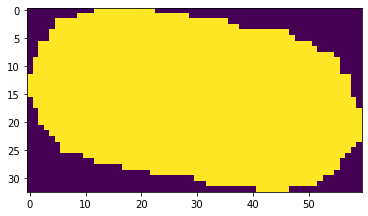

   Shape:
   id 2028



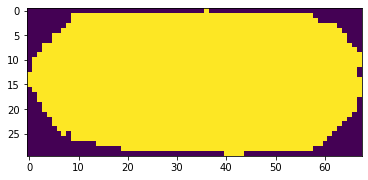

   Shape:
   id 2029



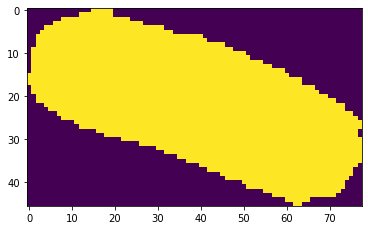

   Shape:
   id 2030



   Shape:
   id 2031



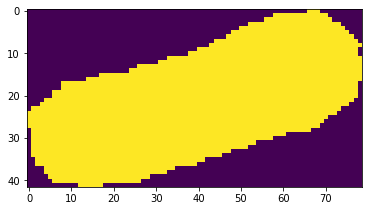

   Shape:
   id 2032



   Shape:
   id 2033



   Shape:
   id 2034



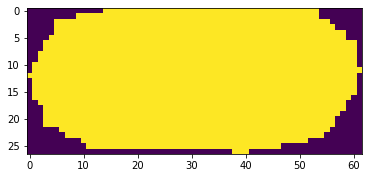

   Shape:
   id 2035



   Shape:
   id 2036



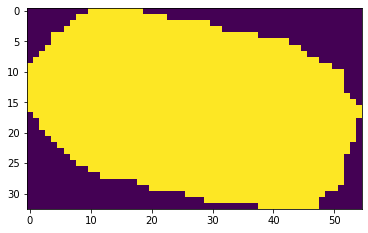

   Shape:
   id 2037



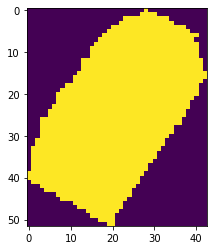

   Shape:
   id 2038



   Shape:
   id 2039



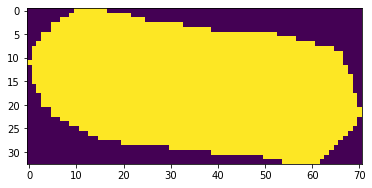

   Shape:
   id 2040



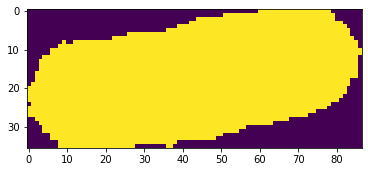

   Shape:
   id 2041



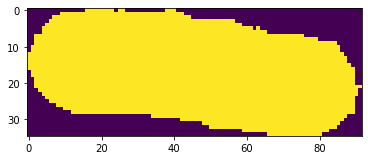

   Shape:
   id 2042



   Shape:
   id 2043



   Shape:
   id 2044



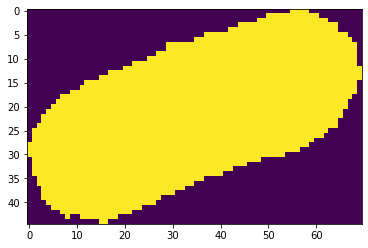

   Shape:
   id 2045



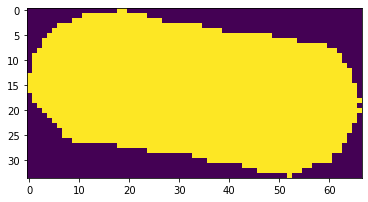

   Shape:
   id 2046



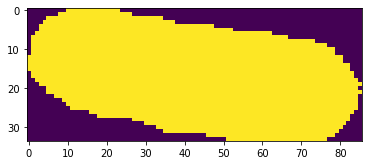

   Shape:
   id 2047



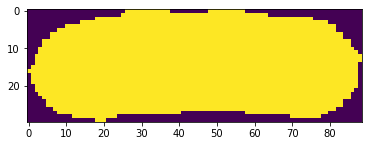

   Shape:
   id 2048



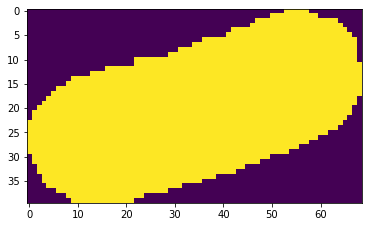

   Shape:
   id 2049



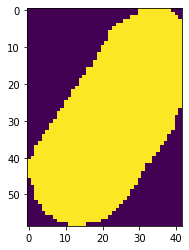

   Shape:
   id 2050



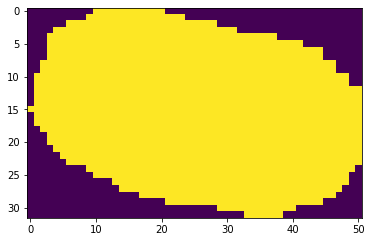

   Shape:
   id 2051



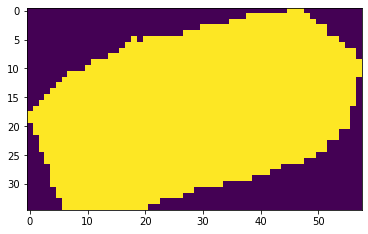

   Shape:
   id 2052



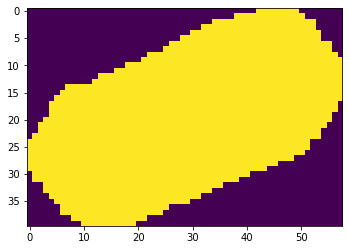

   Shape:
   id 2053



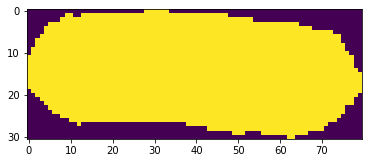

   Shape:
   id 2054



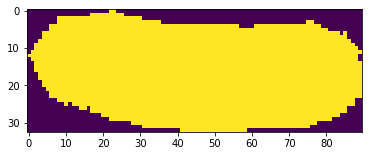

   Shape:
   id 2055



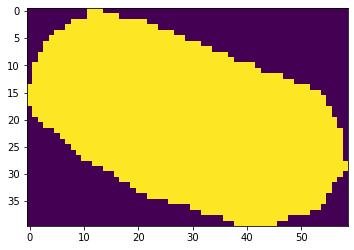

   Shape:
   id 2056



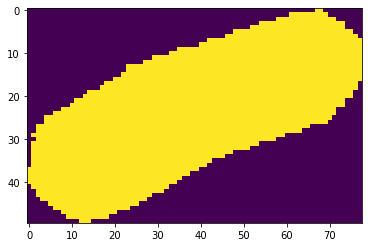

   Shape:
   id 2057



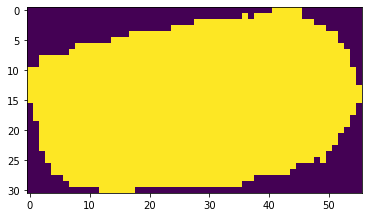

   Shape:
   id 2058



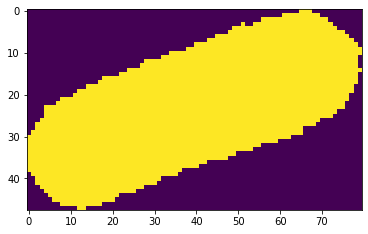

   Shape:
   id 2059



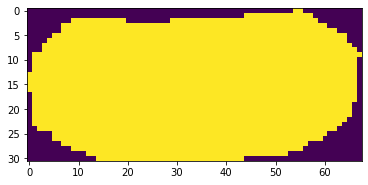

   Shape:
   id 2060



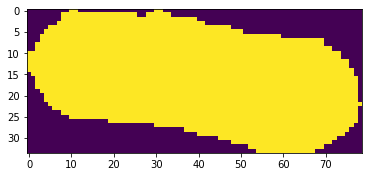

   Shape:
   id 2061



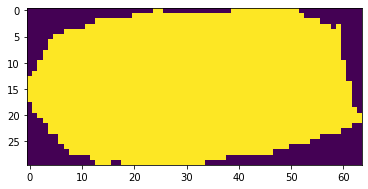

   Shape:
   id 2062



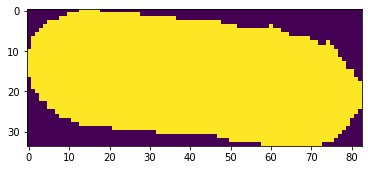

   Shape:
   id 2063



   Shape:
   id 2064



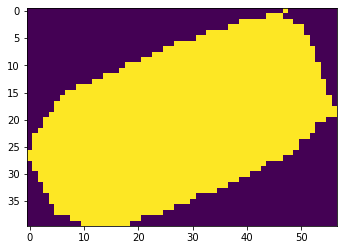

   Shape:
   id 2065



   Shape:
   id 2066



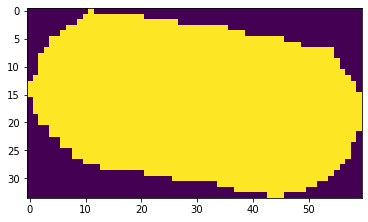

   Shape:
   id 2067



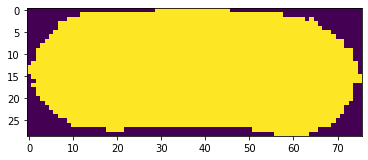

   Shape:
   id 2068



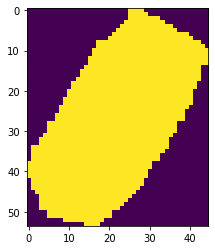

   Shape:
   id 2069



   Shape:
   id 2070



   Shape:
   id 2071



   Shape:
   id 2072



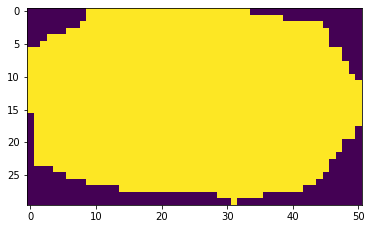

   Shape:
   id 2073



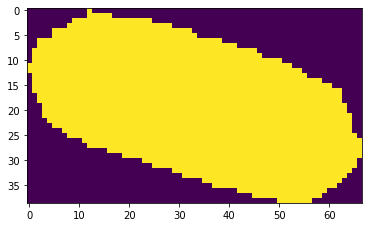

   Shape:
   id 2074



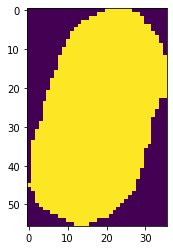

   Shape:
   id 2075



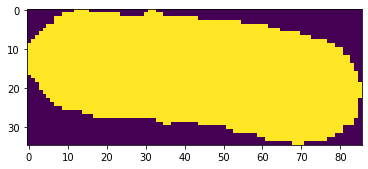

   Shape:
   id 2076



   Shape:
   id 2077



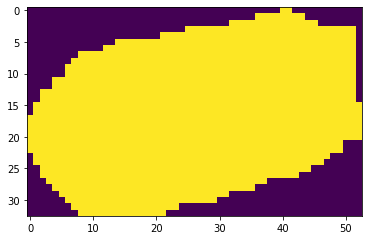

   Shape:
   id 2078



   Shape:
   id 2079



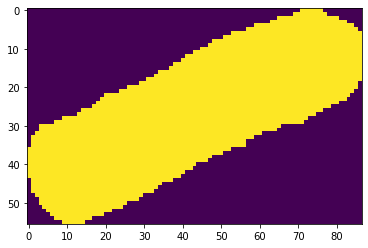

   Shape:
   id 2080



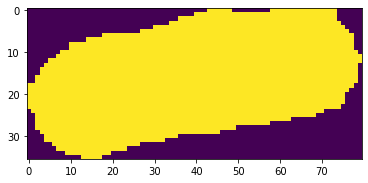

   Shape:
   id 2081



   Shape:
   id 2082



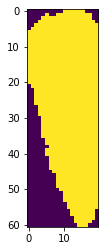

   Shape:
   id 2083



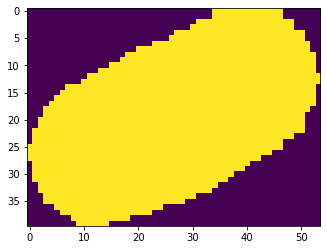

   Shape:
   id 2084



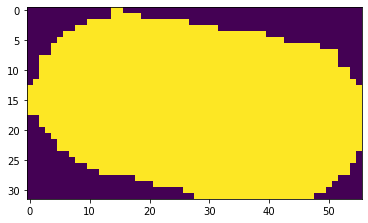

   Shape:
   id 2085



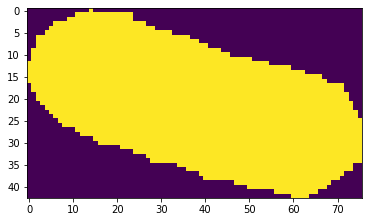

   Shape:
   id 2086



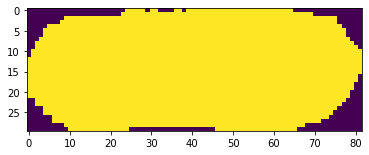

   Shape:
   id 2087



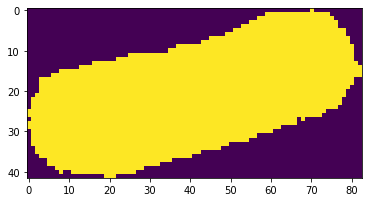

   Shape:
   id 2088



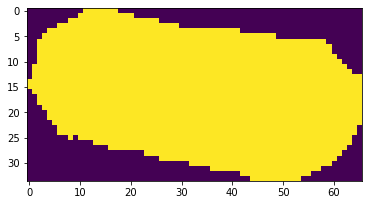

   Shape:
   id 2089



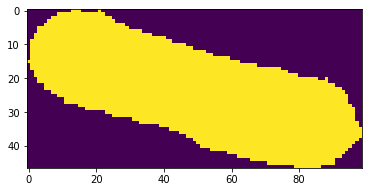

   Shape:
   id 2090



   Shape:
   id 2091



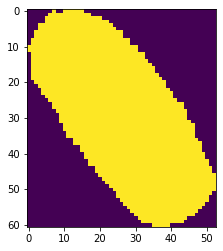

   Shape:
   id 2092



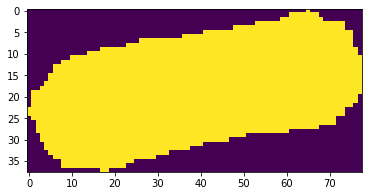

   Shape:
   id 2093



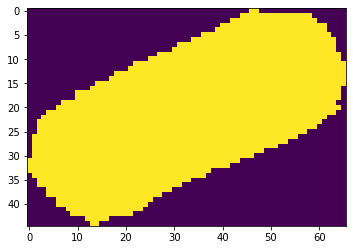

   Shape:
   id 2094



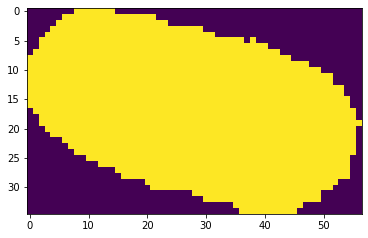

   Shape:
   id 2095



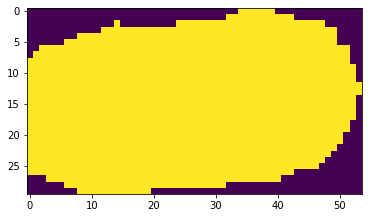

   Shape:
   id 2096



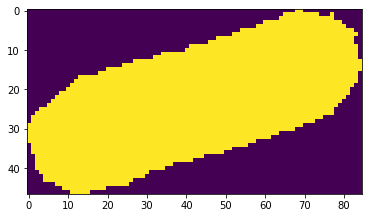

   Shape:
   id 2097



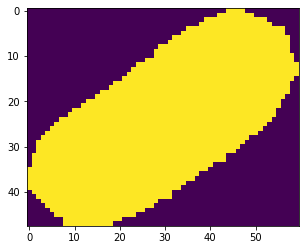

   Shape:
   id 2098



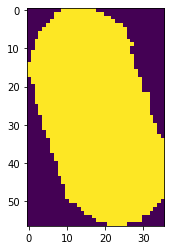

   Shape:
   id 2099



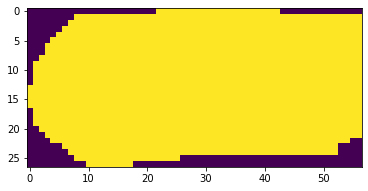

   Shape:
   id 2100



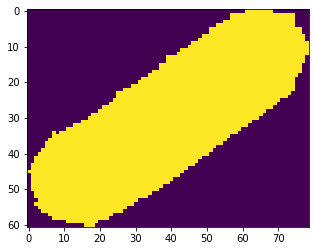

   Shape:
   id 2101



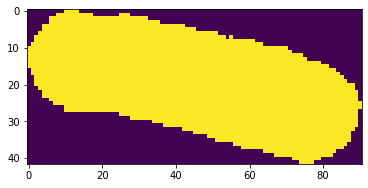

   Shape:
   id 2102



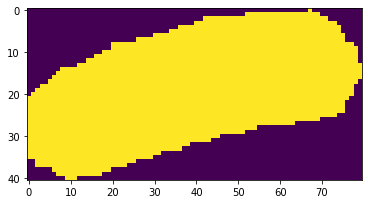

   Shape:
   id 2103



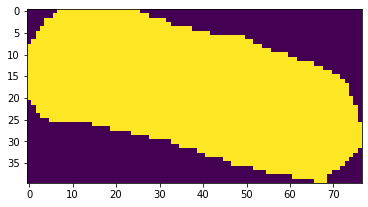

   Shape:
   id 2104



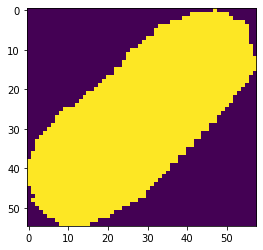

   Shape:
   id 2105



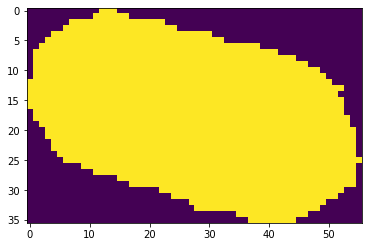

   Shape:
   id 2106



   Shape:
   id 2107



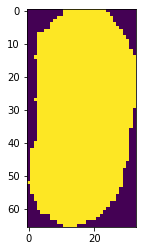

   Shape:
   id 2108



   Shape:
   id 2109



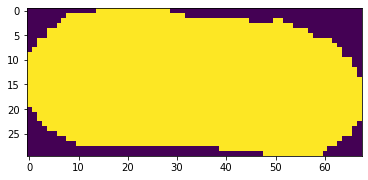

   Shape:
   id 2110



   Shape:
   id 2111



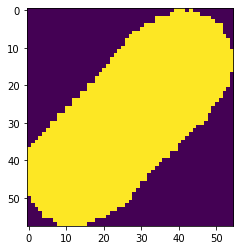

   Shape:
   id 2112



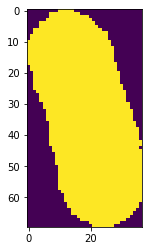

   Shape:
   id 2113



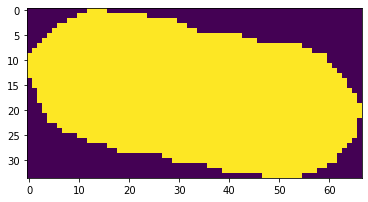

   Shape:
   id 2114



   Shape:
   id 2115



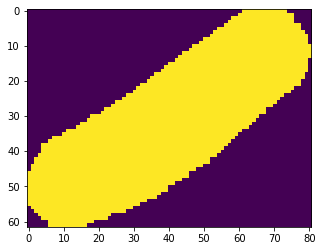

   Shape:
   id 2116



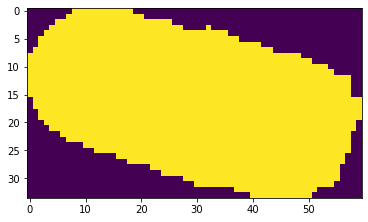

   Shape:
   id 2117



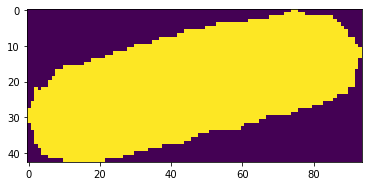

   Shape:
   id 2118



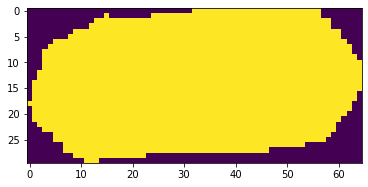

   Shape:
   id 2119



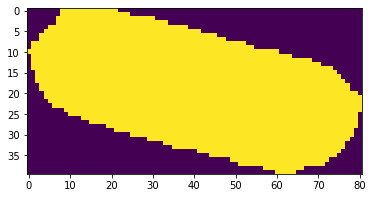

   Shape:
   id 2120



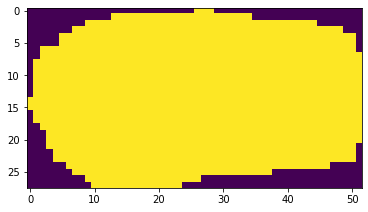

   Shape:
   id 2121



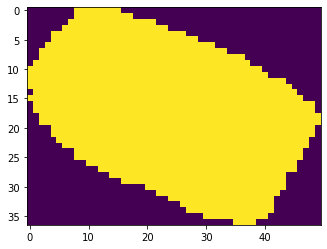

   Shape:
   id 2122



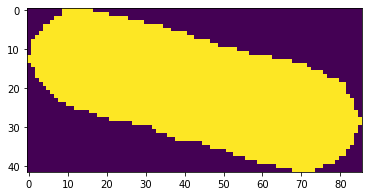

   Shape:
   id 2123



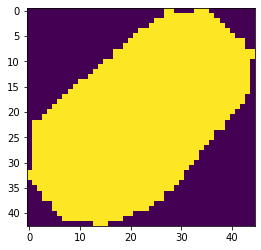

   Shape:
   id 2124



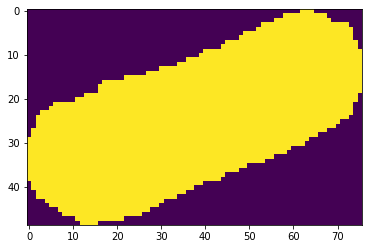

   Shape:
   id 2125



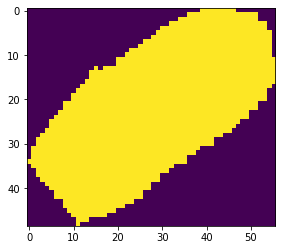

   Shape:
   id 2126



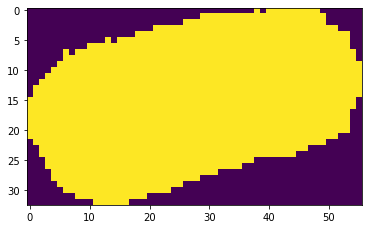

   Shape:
   id 2127



   Shape:
   id 2128



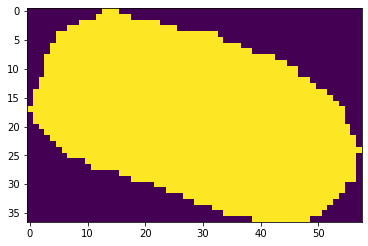

   Shape:
   id 2129



   Shape:
   id 2130



   Shape:
   id 2131



   Shape:
   id 2132



   Shape:
   id 2133



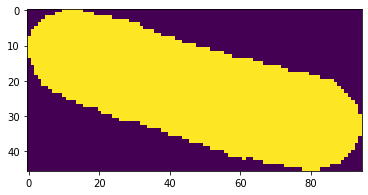

   Shape:
   id 2134



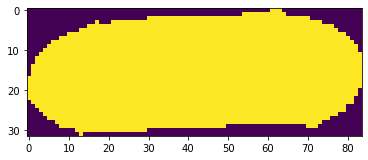

   Shape:
   id 2135



   Shape:
   id 2136



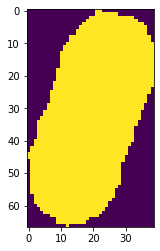

   Shape:
   id 2137



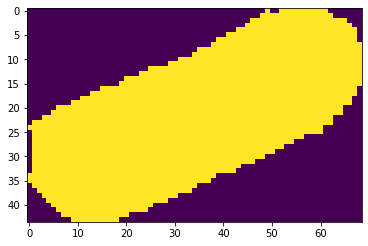

   Shape:
   id 2138



   Shape:
   id 2139



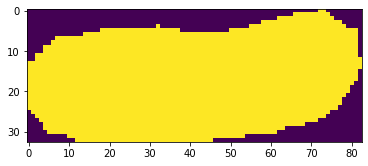

   Shape:
   id 2140



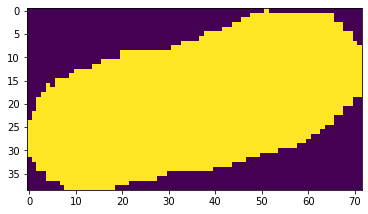

   Shape:
   id 2141



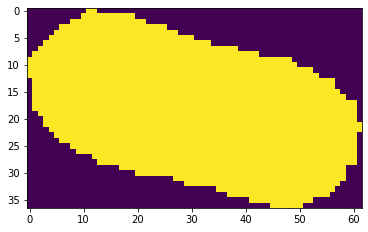

   Shape:
   id 2142



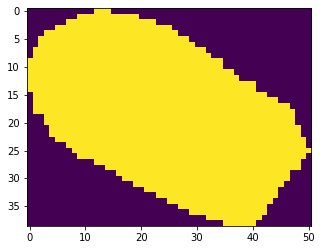

   Shape:
   id 2143



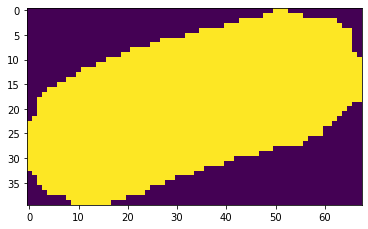

   Shape:
   id 2144



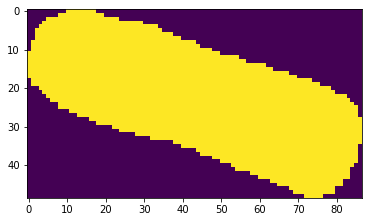

   Shape:
   id 2145



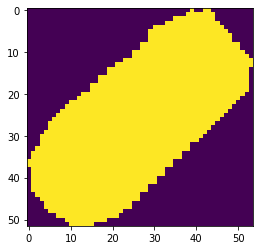

   Shape:
   id 2146



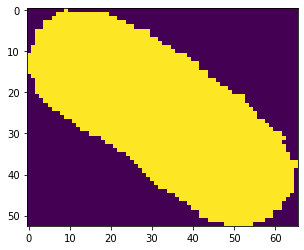

   Shape:
   id 2147



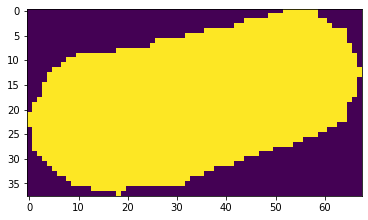

   Shape:
   id 2148



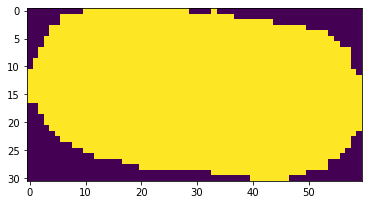

   Shape:
   id 2149



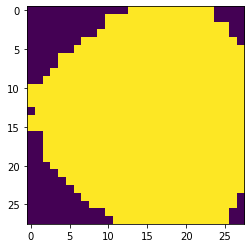

   Shape:
   id 2150



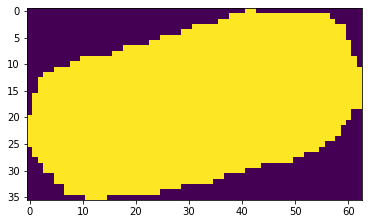

   Shape:
   id 2151



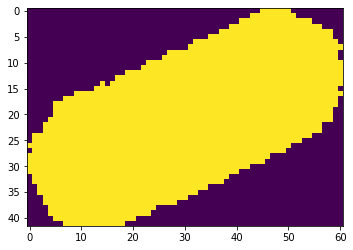

   Shape:
   id 2152



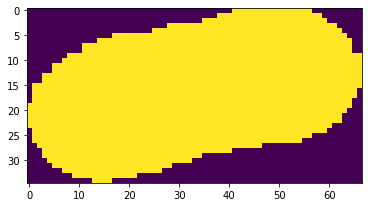

   Shape:
   id 2153



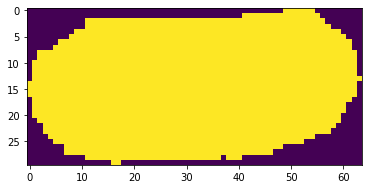

   Shape:
   id 2154



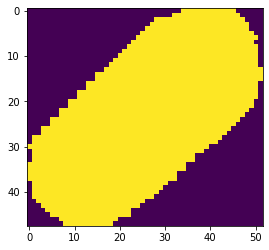

   Shape:
   id 2155



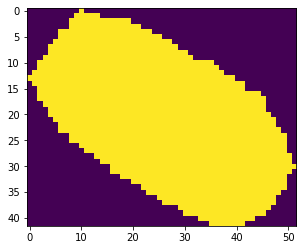

   Shape:
   id 2156



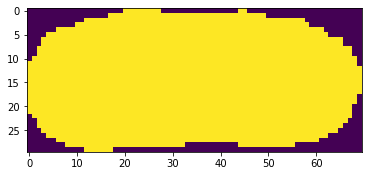

   Shape:
   id 2157



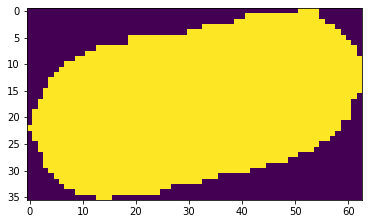

   Shape:
   id 2158



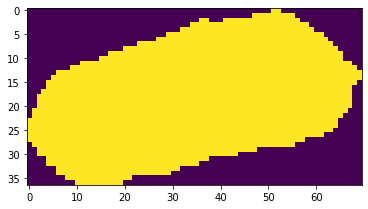

   Shape:
   id 2159



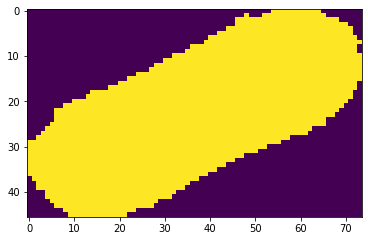

   Shape:
   id 2160



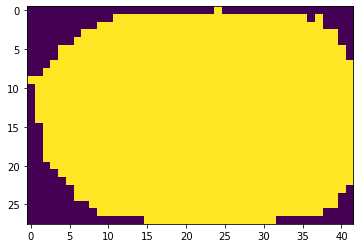

   Shape:
   id 2161



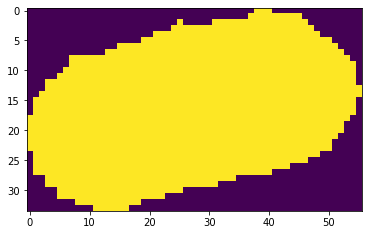

   Shape:
   id 2162



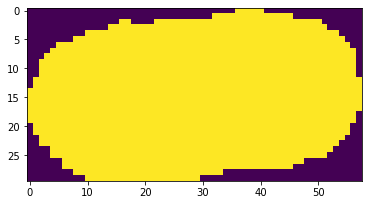

   Shape:
   id 2163



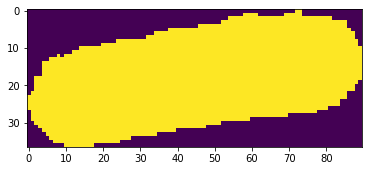

   Shape:
   id 2164



   Shape:
   id 2165



In [7]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(imageId, None)
for roi in result.rois:
    print("ROI:  ID:", roi.getId().getValue())
    for s in roi.copyShapes():
        shape = {}
        shape['id'] = s.getId().getValue()
        if s.getTextValue():
            shape['textValue'] = s.getTextValue().getValue()
        if type(s) == omero.model.MaskI:
            binarray, (t, c, z, y, x, h, w) = mask_to_arr(s)
            plt.imshow(binarray)
            plt.show()
        # Do some processing here, or just print:
        print("   Shape:",)
        for key, value in shape.items():
            print("  ", key, value,)
        print("")

In [67]:
mng_channel= 0
mng = pixels.getPlane(0, mng_channel, 0)
finalMask = np.zeros_like(mng)
#sample = regionprops(binarray)[0]
#target = mng[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
#plt.imshow(target)
cut = mng[y:y+binarray.shape[0],x:x+binarray.shape[1]]
f,axs = plt.subplots(ncols=2,figsize=(10,5))
axs[0].imshow(cut)
axs[1].imshow(binarray)


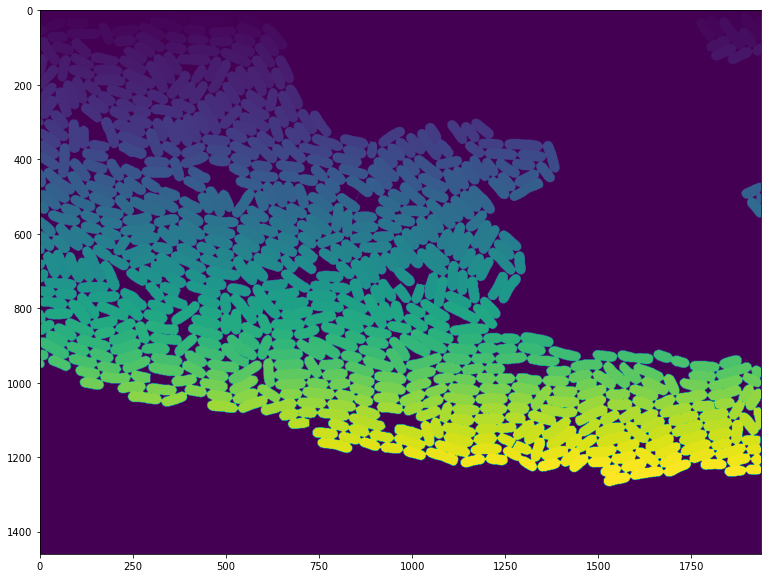

C:\Users\sakkosjo\Anaconda3\envs\omero\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


In [21]:
mng_channel= 0
mng = pixels.getPlane(0, mng_channel, 0)
dsred = pixels.getPlane(0, 1, 0)
# recreate mask by stitching together mask rois
mask = np.zeros_like(mng)
for roi in result.rois:
    for i,s in enumerate(roi.copyShapes()):
        if type(s) == omero.model.MaskI:
            binarray, (t, c, z, y, x, h, w) = mask_to_arr(s)
            mask[y:y+binarray.shape[0],x:x+binarray.shape[1]] = binarray*i + mask[y:y+binarray.shape[0],x:x+binarray.shape[1]]

# plot reconstructed mask            
f, ax = plt.subplots(figsize=(16,10))
ax.imshow(mask)
plt.show()

#label and plot labelled mask
labelled_image = label(mask)
feature_table = regionprops(labelled_image)

plt.figure(figsize=(16,8))
plt.imshow(label2rgb(labelled_image,dsred))
plt.yticks([])
plt.xticks([])
plt.axis('off') 
plt.show()







 



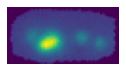

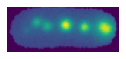

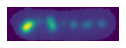

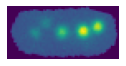

In [22]:
CellSize_label = []
Averaged_GFP_2D = np.zeros([200, 500]) #average fluorescence over the entire cell

for i in feature_table:
    if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
        CellSize_label.append(i.label)
n=0
for i in np.argsort(CellSize_label):
    sample = feature_table[CellSize_label[i]-1]
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = mng[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = target_channel * sample.filled_image
    rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
    masked = target_channel[target_channel > 0]
    H, W = rotated_image.shape
    image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
    Averaged_GFP_2D = Averaged_GFP_2D + sk.transform.resize(image_center, (Averaged_GFP_2D.shape[0],Averaged_GFP_2D.shape[1]))

    if n%100 == 1:
      plt.figure(figsize=(2,2))
      plt.imshow(image_center)
      plt.yticks([])
      plt.xticks([])
      plt.axis('off')  
      plt.show()
    n+=1

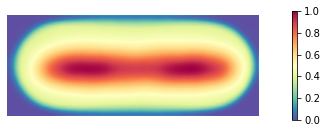

In [65]:

#from .colorbar import Colorbar
f, ax = plt.subplots()

vmax = Averaged_GFP_2D.max()
vmin = Averaged_GFP_2D.min()
cmap = plt.cm.Spectral_r
alphas = Normalize(0, 1, clip=True)(Averaged_GFP_2D)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom at .4

colors = Normalize(vmin, vmax)(Averaged_GFP_2D)
#colors = cmap(colors)
#colors[..., -1] = alphas
im = ax.imshow(colors,cmap=cmap)
ax.set_axis_off()
cbar = plt.colorbar(im, pad=0.1,shrink=.5)


In [ ]:
def disconnect(conn):
    """
    Disconnect from an OMERO server
    :param conn: The BlitzGateway
    """
    conn.close()

disconnect(conn)